# Import 

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import qutip as qt
from copy import deepcopy
import scipy as sp


import experiments as meas
from experiments.MM_dual_rail_base import MM_dual_rail_base
from fitting.fit_display_classes import GeneralFitting
from fitting.wigner import WignerAnalysis

from slab import AttrDict
from experiments import MultimodeStation, CharacterizationRunner, SweepRunner

from job_server import JobClient
from job_server.database import get_database
from job_server.config_versioning import ConfigVersionManager

# Initialize database and config manager
db = get_database()
config_dir = 'D:/python/multimode_expts/configs'
config_manager = ConfigVersionManager(config_dir)

# Initialize job client (handle submitting and waiting for jobs)
client = JobClient()

# Check server health
health = client.health_check()
print(f"Server status: {health['status']}")
print(f"Pending jobs: {health['pending_jobs']}")

user = "seb"
print("Welcome", user)


station = MultimodeStation(
    user=user,
    experiment_name = "250119_qec",
)

active_reset_dict = {
    'active_reset': True, # on recalibration of readout, turn off active reset because it will be wrong for selecting when to apply the qubit pulse
    'ef_reset': True,
    'storage_reset': False,
    'coupler_reset': False,
    'pre_selection_reset': True,
    'man_reset': False, 
    'use_qubit_man_reset': True, # whether to use the qubit
    'pre_selection_parity':True,
}


USE_QUEUE = True
mm_base_calib = MM_dual_rail_base(station.hardware_cfg, station.soc)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Server status: healthy
Pending jobs: 0
Welcome seb
[STATION] Using main hardware_config version: CFG-HW-20260210-00009
[STATION] Using main multiphoton_config version: CFG-MP-20260121-00001
[STATION] Using main man1_storage_swap version: CFG-M1-20260205-00075
[STATION] Using main floquet_storage_swap version: CFG-FL-20260205-00029
Data, plots, logs will be stored in: D:\experiments\250119_qec
Hardware configs will be read from D:\python\multimode_expts\configs\versions\hardware_config\CFG-HW-20260210-00009.yml
dict_keys(['Pyro.NameServer', 'Qick101'])
QICK running on ZCU216, software version 0.2.291

Firmware configuration (built Tue Oct 15 12:06:51 2024):

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, bl

# Calibrate single shot 

In [3]:
# Define defaults, smart config preprocessing and post-measurement updates
# =====================================
singleshot_defaults = AttrDict(dict(    
    reps=5000,
    relax_delay=500,
    check_f=False,
    active_reset=False,
    man_reset=False,
    storage_reset=False,
    qubit=0,
    pulse_manipulate=False,
    cavity_freq=4984.373226159381,
    cavity_gain=400,
    cavity_length=2,
    prepulse=False,
    pre_sweep_pulse=None,
    gate_based=True,
    qubits=[0],
)) # Shouldn't be modifying this on the fly!
# You can use kwargs in the run function to override these values



def singleshot_postproc(station, expt):
    expt.analyze(plot=False, station=station, subdir=station.autocalib_path)
    fids = expt.data['fids']
    confusion_matrix = expt.data['confusion_matrix']
    thresholds_new = expt.data['thresholds']
    angle = expt.data['angle']
    print(fids)

    hardware_cfg = station.hardware_cfg
    hardware_cfg.device.readout.phase = [hardware_cfg.device.readout.phase[0] + angle]
    hardware_cfg.device.readout.threshold = thresholds_new
    hardware_cfg.device.readout.threshold_list = [thresholds_new]
    hardware_cfg.device.readout.Ie = [np.median(expt.data['Ie_rot'])]
    hardware_cfg.device.readout.Ig = [np.median(expt.data['Ig_rot'])]
    if expt.cfg.expt.active_reset:
        hardware_cfg.device.readout.confusion_matrix_with_active_reset = confusion_matrix
    else:
        hardware_cfg.device.readout.confusion_matrix_without_reset = confusion_matrix
    print('Updated readout!')

    expt.display(station)

Job submitted: JOB-20260210-00038 (queue position: 1)

[0.2s] Job JOB-20260210-00038: pending

[2.2s] Job JOB-20260210-00038: running
[WORKER] Loading HistogramExperiment from experiments.single_qubit.single_shot
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260210-00038_HistogramExperiment.h5
[WORKER] Running experiment...
[WORKER] Setting coupler yoko current to 0.5mA according to hardware_cfg yaml...
[WORKER] Done setting coupler current
man_reset: False
storage_reset: False
coupler_reset: False
ef_reset: True
pre_selection_reset: True
use_qubit_man_reset: True
pre_selection_parity: True
man_idx: 1
parity_fast: False
100%|█████████████████████████████████████| 5000/5000 [00:10<00:00, 495.39it/s]
man_reset: False
storage_reset: False
coupler_reset: False
ef_reset: True
pre_selection_reset: True
use_qubit_man_reset: True
pre_selection_parity: True
man_idx: 1
parity_fast: False
 74%|███████████████████████████▏         | 3681/5000 [00:07<00:02, 495.24it/s]
[26.4s] J

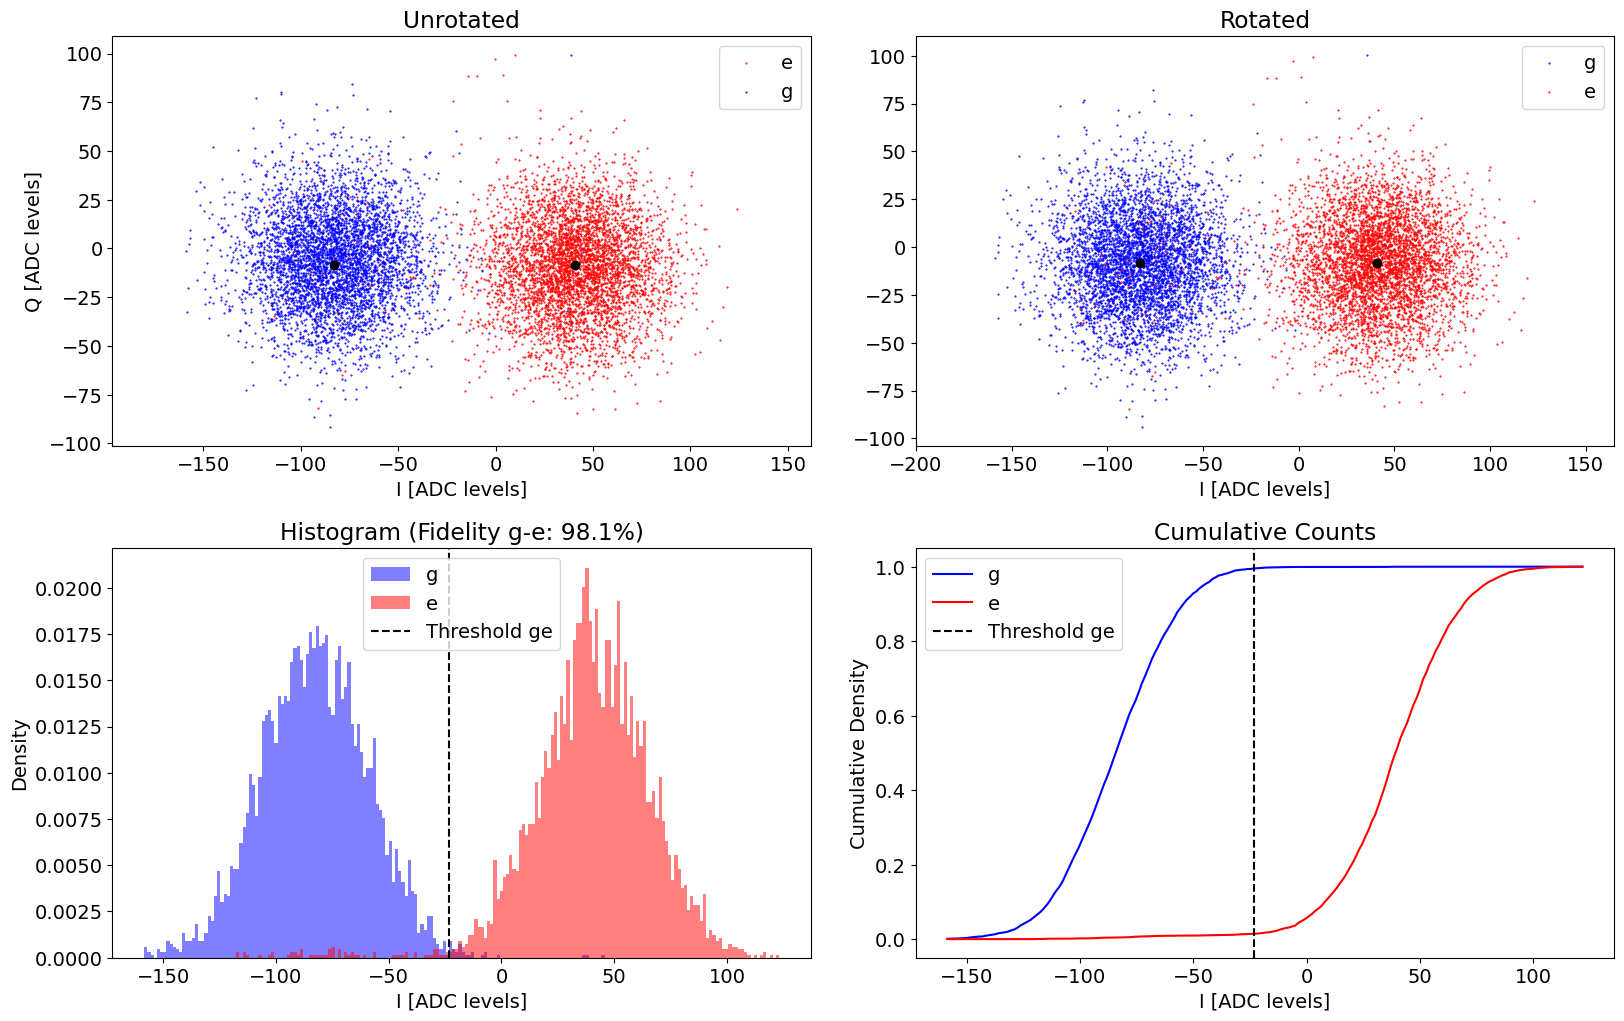

Plot saved to D:\experiments\250119_qec\plots\2026-02-10_10-49-24_histogram.png
Plot reference appended to D:\experiments\250119_qec\logs\2026-02-10.md
ge fidelity (%): 98.09008658995802
rotation angle (deg): 1.680167639363421
threshold ge: -23.297214895697664


In [4]:
single_shot_runner = CharacterizationRunner(
    station = station,
    ExptClass = meas.HistogramExperiment,
    default_expt_cfg = singleshot_defaults,
    postprocessor = singleshot_postproc,
    job_client=client,
    use_queue=USE_QUEUE,
)

single_shot = single_shot_runner.execute(
        go_kwargs=dict(analyze=False, display=False),
        check_f=False,
        relax_delay=2000,
        gate_based=False,
        **active_reset_dict,
    )

# Calibrate the beam splitter 

In [ ]:
# Helper function (kept from original)
def get_storage_mode_parameters(ds_storage, config_thisrun, man_mode_no, stor_mode_no):
    """Get pulse parameters for a given storage mode."""
    stor_name = 'M' + str(man_mode_no) + '-S' + str(stor_mode_no)
    freq = ds_storage.get_freq(stor_name)
    gain = ds_storage.get_gain(stor_name)
    pi_len = ds_storage.get_pi(stor_name)
    h_pi_len = ds_storage.get_h_pi(stor_name)
    flux_low_ch = config_thisrun.hw.soc.dacs.flux_low.ch
    flux_high_ch = config_thisrun.hw.soc.dacs.flux_high.ch
    ch = flux_low_ch if freq < 1000 else flux_high_ch

    mm_base_dummy = MM_dual_rail_base(config_thisrun, soccfg=station.soc)
    prepulse = mm_base_dummy.prep_man_photon(man_mode_no)
    postpulse = mm_base_dummy.prep_man_photon(man_mode_no)
    # prepulse = mm_base_dummy.get_prepulse_creator(prepulse).pulse.tolist()
    # postpulse = mm_base_dummy.get_prepulse_creator(prepulse[-1:-3:-1]).pulse.tolist()

    return freq, gain, pi_len, h_pi_len, ch, prepulse, postpulse


# Configuration defaults for error amplification
error_amp_stor_defaults = AttrDict(dict(
    reps=50,
    rounds=1,
    qubit=0,
    qubits=[0],
    n_start=0,
    n_step=3,
    n_pulses=15,
    expts=50,
    active_reset=False,
    man_reset=True,
    storage_reset=True,
    relax_delay=2500,
    qubit_state_start='g',
))


def error_amp_stor_preproc(station, default_expt_cfg, man_mode_no=1, stor_mode_no=1, 
                           parameter_to_test='gain', span=None, start=None, **kwargs):
    """Preprocessor for error amplification storage."""
    expt_cfg = deepcopy(default_expt_cfg)
    expt_cfg.update(kwargs)
    
    stor_name = f'M{man_mode_no}-S{stor_mode_no}'
    
    # Get current values
    freq, gain, pi_len, h_pi_len, ch, prepulse, postpulse = get_storage_mode_parameters(
        station.ds_storage, station.hardware_cfg, man_mode_no, stor_mode_no
    )    
    # Set pulse type for storage mode
    expt_cfg.pulse_type = ['storage', stor_name, 'pi', 0]
    expt_cfg.parameter_to_test = parameter_to_test
    
    # Set sweep range based on parameter
    if parameter_to_test == 'gain':
        if span is None:
            span = int(gain * 0.3)  # 30% of current gain
        if start is None:
            expt_cfg.start = int(gain - span / 2)

        expt_cfg.step = int(span / (expt_cfg.expts - 1))
    elif parameter_to_test == 'frequency':
        if span is None:
            span = 0.15  # MHz
        if start is None:
            expt_cfg.start = freq - span / 2
        expt_cfg.step = span / (expt_cfg.expts - 1)
    
    print(f'Error amp ({parameter_to_test}) for {stor_name}: center={freq if parameter_to_test=="frequency" else gain}, span={span}')
    
    return expt_cfg


In [62]:
expts_to_run = {
                #storage
                'stor_modes': [1], # [1,2, .., 7] if also want to run  all modes 
                }
man_mode_no = 1

In [ ]:
length_vectors = {}
gain_vectors = {}
freq_vectors = {}
num_pts = 20
qubit_states = ['g', 'e']

for stor_mode_no in expts_to_run.get('stor_modes', [1]):
    freq, gain, pi_len, h_pi_len, ch, prepulse, postpulse = get_storage_mode_parameters(
        station.ds_storage, station.hardware_cfg, man_mode_no, stor_mode_no
    )

    len_min = (pi_len * 0.3)
    len_max = (pi_len * 1.2)


    gain_min = gain * pi_len / len_max
    gain_max = gain * pi_len / len_min
    print(f"Gain range for storage mode {stor_mode_no}: {gain_min} to {gain_max}")

    
    # Initialize nested dicts for this mode
    length_vectors[stor_mode_no] = {}
    gain_vectors[stor_mode_no] = {}
    freq_vectors[stor_mode_no] = {}
    
    for qubit_state in qubit_states:
        gain_vectors[stor_mode_no][qubit_state] = np.linspace(gain_min, gain_max, num=num_pts)
        length_vectors[stor_mode_no][qubit_state] = pi_len * gain / gain_vectors[stor_mode_no][qubit_state]
        freq_vectors[stor_mode_no][qubit_state] = np.linspace(freq, freq, num=num_pts)
        if qubit_state == 'e':
            freq_vectors[stor_mode_no][qubit_state] += station.hardware_cfg.device.manipulate.chi_ge[man_mode_no - 1]
    
    print(f"Storage mode {stor_mode_no}:")
    print("Length vectors:", length_vectors[stor_mode_no])
    print("Gain vectors:", gain_vectors[stor_mode_no])
    print("Frequency vectors:", freq_vectors[stor_mode_no])

In [ ]:
qubit_start = 'e'
reps = 100
n_steps = 3
n_pulses = 10
analyze = False
display = False 

In [ ]:
# Error Amplification Storage - New Pattern with CharacterizationRunner

# Example execution - gain optimization followed by frequency optimization
for stor_mode_no in expts_to_run.get('stor_modes', [1]):
    stor_name = f'M1-S{stor_mode_no}'

    original_freq, original_gain, original_pi_len, h_pi_len, ch, prepulse, postpulse = get_storage_mode_parameters(
        station.ds_storage, station.hardware_cfg, man_mode_no, stor_mode_no
    )

    # set the pi_length, gain and frequency to be tested
    for idx, pi_len_test in enumerate(length_vectors[stor_mode_no][qubit_start]):
        station.ds_storage.update_pi(stor_name, pi_len_test)
        _idx = idx if idx==0 else idx-1
        station.ds_storage.update_gain(stor_name, gain_vectors[stor_mode_no][qubit_start][idx])  
        station.ds_storage.update_freq(stor_name, freq_vectors[stor_mode_no][qubit_start][_idx]) 
        print(station.ds_storage.get_pi(stor_name)) 

        print(f'Running error amp (frequency) for {stor_name}')
        print(f"Testing pi length: {pi_len_test} us, gain: {gain_vectors[stor_mode_no][qubit_start][idx]}, frequency: {freq_vectors[stor_mode_no][qubit_start][_idx]} MHz")
        # Round 1: Frequency optimization

        error_amp_stor_runner = CharacterizationRunner(
            station=station,
            ExptClass=meas.single_qubit.error_amplification.ErrorAmplificationExperiment,
            default_expt_cfg=error_amp_stor_defaults,
            preprocessor=error_amp_stor_preproc,
            # postprocessor=error_amp_stor_postproc,
            job_client=client,
            use_queue=USE_QUEUE,
        )
        error_amp_freq = error_amp_stor_runner.execute(
            man_mode_no=man_mode_no,
            stor_mode_no=stor_mode_no,
            parameter_to_test='frequency',
            span=0.2,
            n_step=n_steps,
            n_pulses=n_pulses,
            analyze=analyze,
            display=display,
            reps=reps,
            qubit_state_start=qubit_start,
        )

        # update frequency based on optimization

        error_amp_freq.analyze(state_fin='e')
        error_amp_freq.display()
        optimal_value_freq = error_amp_freq.data['fit_avgi'][2]
        freq_vectors[stor_mode_no][qubit_start][idx] = optimal_value_freq
        station.ds_storage.update_freq(stor_name, optimal_value_freq)
        print(f'Updated frequency for {stor_name}: {optimal_value_freq:.4f} MHz')

        # Round 2: Gain optimization
        print(f'Running error amp (gain) for {stor_name}')
        error_amp_stor_runner = CharacterizationRunner(
            station=station,
            ExptClass=meas.single_qubit.error_amplification.ErrorAmplificationExperiment,
            default_expt_cfg=error_amp_stor_defaults,
            preprocessor=error_amp_stor_preproc,
            # postprocessor=error_amp_stor_postproc,
            job_client=client,
            use_queue=USE_QUEUE,
        )
        error_amp_gain = error_amp_stor_runner.execute(
            man_mode_no=man_mode_no,
            stor_mode_no=stor_mode_no,
            parameter_to_test='gain',
            span=int(gain_vectors[stor_mode_no][qubit_start][idx] * 0.35),
            n_step=n_steps,
            n_pulses=n_pulses,
            analyze=analyze,
            display=display,
            reps=reps,
            qubit_state_start=qubit_start,
        )

        # update gain based on optimization
        error_amp_gain.analyze(state_fin='e')
        error_amp_gain.display()
        optimal_value_gain = error_amp_gain.data['fit_avgi'][2]
        gain_vectors[stor_mode_no][qubit_start][idx] = optimal_value_gain
        station.ds_storage.update_gain(stor_name, int(optimal_value_gain))
        print(f'Updated gain for {stor_name}: {int(optimal_value_gain)}')


        # Final Round: Frequency optimization
        print(f'Running final error amp (frequency) for {stor_name}')

        error_amp_stor_runner = CharacterizationRunner(
            station=station,
            ExptClass=meas.single_qubit.error_amplification.ErrorAmplificationExperiment,
            default_expt_cfg=error_amp_stor_defaults,
            preprocessor=error_amp_stor_preproc,
            # postprocessor=error_amp_stor_postproc,
            job_client=client,
            use_queue=USE_QUEUE,
        )
        error_amp_freq_final = error_amp_stor_runner.execute(
            man_mode_no=man_mode_no,
            stor_mode_no=stor_mode_no,
            parameter_to_test='frequency',
            span=0.1,
            n_step=n_steps,
            n_pulses=n_pulses,
            analyze=analyze,
            display=display,
            reps=reps,
            qubit_state_start=qubit_start,
        )

        # update frequency based on optimization
        error_amp_freq_final.analyze(state_fin='e')
        error_amp_freq_final.display()
        optimal_value_freq_final = error_amp_freq_final.data['fit_avgi'][2]
        freq_vectors[stor_mode_no][qubit_start][idx] = optimal_value_freq_final
        station.ds_storage.update_freq(stor_name, optimal_value_freq_final)
        print(f'Updated frequency for {stor_name}: {optimal_value_freq_final:.4f} MHz')
        

    
    # restore original parameters after length sweep
    station.ds_storage.update_pi(stor_name, original_pi_len)
    station.ds_storage.update_gain(stor_name, original_gain)
    station.ds_storage.update_freq(stor_name, original_freq)
        



In [ ]:
# from the pulse length we compute the beam-splitter rate and plot is versus gain, same for frequency 

degree_rate = 2
degree_freq = 10


beam_splitter_rates = {}
for stor_mode_no in expts_to_run.get('stor_modes', [1]):
    beam_splitter_rates[stor_mode_no] = {}
    for qubit_state in qubit_states:
        beam_splitter_rates[stor_mode_no][qubit_state] = 0.25 / (length_vectors[stor_mode_no][qubit_state])

for stor_mode_no in expts_to_run.get('stor_modes', [1]):

    bs_coeffs_g = np.polyfit(gain_vectors[stor_mode_no]['g'], beam_splitter_rates[stor_mode_no]['g'], deg=degree_rate)
    bs_coeffs_e = np.polyfit(gain_vectors[stor_mode_no]['e'], beam_splitter_rates[stor_mode_no]['e'], deg=degree_rate)
    freq_coeffs_g = np.polyfit(gain_vectors[stor_mode_no]['g'], freq_vectors[stor_mode_no]['g'], deg=degree_freq)
    freq_coeffs_e = np.polyfit(gain_vectors[stor_mode_no]['e'], freq_vectors[stor_mode_no]['e'], deg=degree_freq)

    # add the fitted curves
    gain_fit_range = np.linspace(min(gain_vectors[stor_mode_no]['g']), max(gain_vectors[stor_mode_no]['g']), 100)
    bs_fit_g = np.polyval(bs_coeffs_g, gain_fit_range)
    bs_fit_e = np.polyval(bs_coeffs_e, gain_fit_range)

    freq_fit_g = np.polyval(freq_coeffs_g, gain_fit_range)
    freq_fit_e = np.polyval(freq_coeffs_e, gain_fit_range)


    fig1, ax1 = plt.subplots(1,2, figsize=(12,5))
    ax1[0].plot(gain_vectors[stor_mode_no]['g'],beam_splitter_rates[stor_mode_no]['g'],  marker='o', label=f'Storage Mode {stor_mode_no}')
    ax1[1].plot(gain_vectors[stor_mode_no]['g'], freq_vectors[stor_mode_no]['g'], marker='o', label=f'Storage Mode {stor_mode_no}')
    ax1[0].plot(gain_fit_range, bs_fit_g, 'r--', label='Fit (g)')
    ax1[1].plot(gain_fit_range, freq_fit_g, 'r--', label='Fit (g)')


    ax1[0].set_xlabel('Gain')
    ax1[0].set_ylabel('Beam Splitter Rate (MHz)')
    ax1[0].set_title('Beam Splitter Rate vs Gain')
    ax1[0].legend()


    fig2, ax2 = plt.subplots(1,2, figsize=(12,5))

    ax2[0].plot(gain_vectors[stor_mode_no]['e'],beam_splitter_rates[stor_mode_no]['e'],  marker='o')
    ax2[1].plot(gain_vectors[stor_mode_no]['e'], freq_vectors[stor_mode_no]['e'], marker='o')
    ax2[0].plot(gain_fit_range, bs_fit_e, 'r--', label='Fit (g)')
    ax2[1].plot(gain_fit_range, freq_fit_e, 'b--', label='Fit (e)')


    ax2[0].set_xlabel('Gain')
    ax2[0].set_ylabel('Beam Splitter Rate (MHz)')
    ax2[0].set_title('Beam Splitter Rate vs Gain')
    ax2[0].legend()

In [ ]:
# Store coefficients and valid gain range
gains_g = gain_vectors[1]['g']
station.ds_storage.update_bs_rate_coeffs('M1-S1', bs_coeffs_g, qubit_state='g')
station.ds_storage.update_freq_coeffs('M1-S1', freq_coeffs_g, qubit_state='g')
station.ds_storage.update_gain_range('M1-S1', gains_g.min(), gains_g.max(), qubit_state='g')

gains_g = gain_vectors[1]['e']
station.ds_storage.update_bs_rate_coeffs('M1-S1', bs_coeffs_e, qubit_state='e')
station.ds_storage.update_freq_coeffs('M1-S1', freq_coeffs_e, qubit_state='e')
station.ds_storage.update_gain_range('M1-S1', gains_g.min(), gains_g.max(), qubit_state='e')




In [ ]:
station.snapshot_man1_storage_swap(update_main=True)

In [ ]:
gain = station.ds_storage.get_freq_at_bs_rate('M1-S1', bs_rate=0.2, qubit_state='g')
print(f"Gain for BS rate 0.2 MHz (g): {gain}")

# Calibrate the flat top pi pulse length 

### First calibrate the pi pulse gain for a given length and flat top sigma.

In [59]:
# Define defaults, smart config preprocessing and post-measurement updates
# =====================================
amprabi_defaults = AttrDict(dict(
    start=0,
    step=60,
    expts=151,
    reps=200,
    rounds=1,
    sigma_test=0.1,
    qubit=0,
    pulse_type='flat_top',
    drag_beta=0.0,
    pulse_ge_init=False,
    pulse_ge_after=False,
    checkZZ=False,
    checkEF=False,
    qubits=[0],
    flat_length=0,
    normalize=False,
    single_shot=False,
    singleshot_reps=10000,
    span=50,
    user_defined_freq=[False, 3568.203829046816],
    prepulse=False,
    postpulse=False, 
    if_ef=False,  # If true, will check ef frequency and update it
)) # Shouldn't be modifying this on the fly!
# You can use kwargs in the run function to override these values

def amprabi_preproc(station, default_expt_cfg, **kwargs):
    expt_cfg = deepcopy(default_expt_cfg)
    expt_cfg.update(kwargs)

    # Copied over but what's all this below????
    # Which ones are actually used? 
    # Can we straighten out all the nested boolean logic???
    pulse_ge = station.hardware_cfg.device.qubit.pulses.pi_ge
    if expt_cfg.sigma_test is None:
        expt_cfg.sigma_test = pulse_ge.sigma[0]
    if expt_cfg.step is None:
        expt_cfg.step = int(pulse_ge.gain[0] / (expt_cfg.expts - 1))
    
    expt_cfg.checkEF = False
    expt_cfg.pulse_ge_init = False
    expt_cfg.pulse_ge_after = False
    if expt_cfg.if_ef:
        expt_cfg.checkEF = True
        expt_cfg.pulse_ge_init = True
        expt_cfg.pulse_ge_after = True
    
    return expt_cfg

def amprabi_postproc(station, expt):
    station.hardware_cfg.device.qubit.pulses.pi_ge.gain = [expt.data['pi_gain_avgi']]
    station.hardware_cfg.device.qubit.pulses.hpi_ge.gain = [expt.data['hpi_gain_avgi']]
    print('Updated qubit ge pi and hpi gaussian gain!')

In [60]:
# Execute
# =================================
amprabi_runner = CharacterizationRunner(
    station = station,
    ExptClass = meas.AmplitudeRabiExperiment,
    default_expt_cfg = amprabi_defaults,
    # preprocessor = amprabi_preproc,
    # postprocessor = amprabi_postproc,
    job_client=client,
    use_queue=USE_QUEUE,
)

In [72]:
N_qubit = 1 # number of 2pi rotation on the qubit 
N_bs = 3 # number of 2pi rotation on the beam splitter
chi_ge = station.hardware_cfg.device.manipulate.chi_ge[man_mode_no - 1]
g_bs_guess = np.abs(chi_ge) * ((N_bs**2 - N_qubit**2) / (4*N_qubit**2 - 1))**1/2
Tp = 1 / np.abs(chi_ge) * (4*N_qubit**2 - 1)** 1/2 * (1 - 1/(4*N_bs**2))**(-1/2)

print(f"Initial guess for beam-splitter rate: {g_bs_guess:.4f} MHz")
print(f"Initial guess for beam-splitter pulse length: {Tp:.4f} us")

gain_qb_pi_pulse = station.hardware_cfg.device.qubit.pulses.pi_ge.gain[0]
sigma_qb_pi_pulse = station.hardware_cfg.device.qubit.pulses.pi_ge.sigma[0]
pi_pulse_type = station.hardware_cfg.device.qubit.pulses.pi_ge.type[0]
assert pi_pulse_type == 'gauss', "Only gaussian pi pulse is supported for now"
n=4 # assume the pulse is 4 sigma long
theta_to_gain = np.pi/2/gain_qb_pi_pulse
drive_to_gain_qb = sigma_qb_pi_pulse * np.sqrt(np.pi)/theta_to_gain * sp.special.erf(n/2)
length_to_gain = drive_to_gain_qb / 4

sigma_flat_top = 0.1
nb_point = 10
# gain_start = 50 
# gain_end  = 100
# gain_vec = np.arange(gain_start, gain_end, (gain_end - gain_start)/nb_point)
# # length_vec = length_to_gain / gain_vec


length_vec = np.linspace(3, 7, num=nb_point)
gain_vec = np.zeros(len(length_vec))
# length_vec = [Tp]
# print("Gain vec:", gain_vec)
print("Length vec:", length_vec)

Initial guess for beam-splitter rate: 0.3736 MHz
Initial guess for beam-splitter pulse length: 5.4289 us
Length vec: [3.         3.44444444 3.88888889 4.33333333 4.77777778 5.22222222
 5.66666667 6.11111111 6.55555556 7.        ]


Length: 3.0
Job submitted: JOB-20260210-00199 (queue position: 1)

[0.1s] Job JOB-20260210-00199: pending

[10.2s] Job JOB-20260210-00199: running
[WORKER] Loading AmplitudeRabiExperiment from experiments.single_qubit.amplitude_rabi
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260210-00199_AmplitudeRabiExperiment.h5
[WORKER] Running experiment...
[WORKER] Setting coupler yoko current to 0.5mA according to hardware_cfg yaml...
[WORKER] Done setting coupler current
 98%|██████████████████████████████████▍| 19656/20000 [00:49<00:00, 399.06it/s]
[66.8s] Job JOB-20260210-00199: completed
100%|███████████████████████████████████| 20000/20000 [00:50<00:00, 399.04it/s]
Attempted to init fitparam 4 to -3.4396125541125553, which is out of bounds -16.27387445887446 to -5.094426406926407. Instead init to -10.684150432900433
Attempted to init fitparam 4 to -10.684150432900433, which is out of bounds 8.215359474283346 to 55.53980091049671. Instead init to 31.877580192390027
Savi

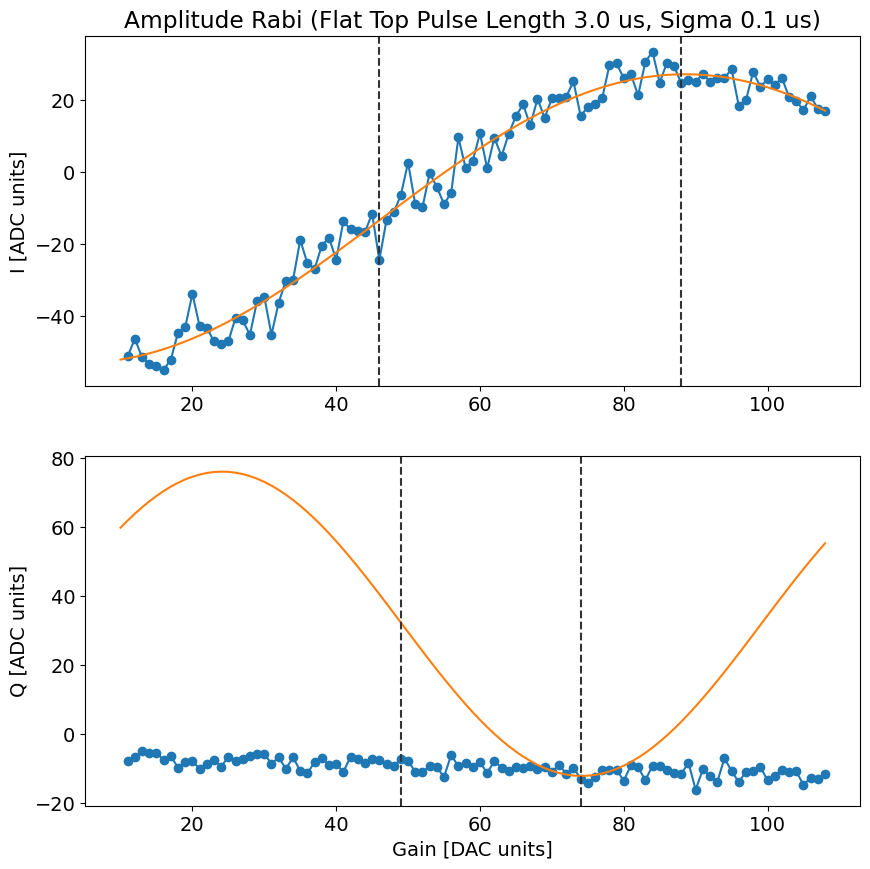

Length: 3.4444444444444446
Job submitted: JOB-20260210-00201 (queue position: 1)

[0.1s] Job JOB-20260210-00201: pending

[14.2s] Job JOB-20260210-00201: running
[WORKER] Loading AmplitudeRabiExperiment from experiments.single_qubit.amplitude_rabi
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260210-00201_AmplitudeRabiExperiment.h5
[WORKER] Running experiment...
[WORKER] Setting coupler yoko current to 0.5mA according to hardware_cfg yaml...
[WORKER] Done setting coupler current
 90%|███████████████████████████████▌   | 18018/20000 [00:45<00:04, 398.97it/s]
[68.8s] Job JOB-20260210-00201: completed
100%|███████████████████████████████████| 20000/20000 [00:50<00:00, 398.96it/s]
Attempted to init fitparam 4 to 0.7287550865800868, which is out of bounds -14.080909090909092 to -4.505270562770563. Instead init to -9.293089826839827
Attempted to init fitparam 4 to -9.293089826839827, which is out of bounds 7.526715199214861 to 46.31513753131436. Instead init to 26.9209263

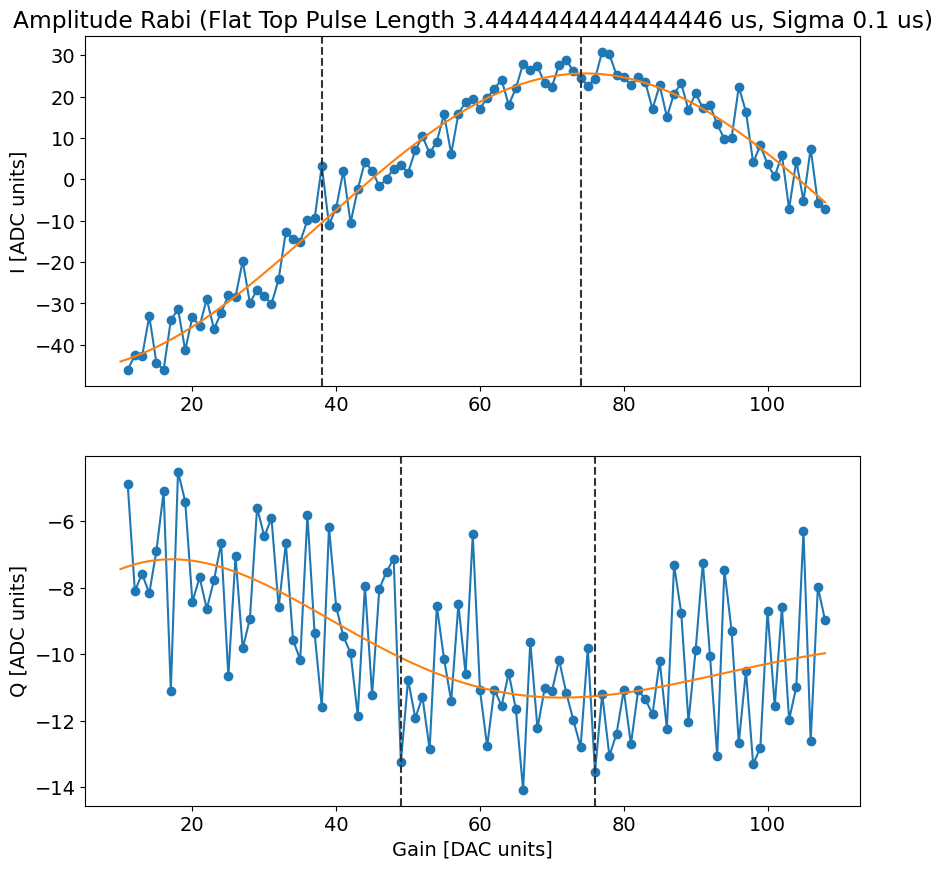

Length: 3.888888888888889
Job submitted: JOB-20260210-00203 (queue position: 1)

[0.1s] Job JOB-20260210-00203: pending

[14.2s] Job JOB-20260210-00203: running
[WORKER] Loading AmplitudeRabiExperiment from experiments.single_qubit.amplitude_rabi
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260210-00203_AmplitudeRabiExperiment.h5
[WORKER] Running experiment...
[WORKER] Setting coupler yoko current to 0.5mA according to hardware_cfg yaml...
[WORKER] Done setting coupler current
 98%|██████████████████████████████████▍| 19656/20000 [00:49<00:00, 398.90it/s]
[70.8s] Job JOB-20260210-00203: completed
100%|███████████████████████████████████| 20000/20000 [00:50<00:00, 398.90it/s]
Attempted to init fitparam 4 to 0.09375995670995657, which is out of bounds -14.993852813852813 to -4.2698484848484854. Instead init to -9.63185064935065
Attempted to init fitparam 4 to -9.63185064935065, which is out of bounds 6.8669045943141445 to 41.453664875178134. Instead init to 24.160284

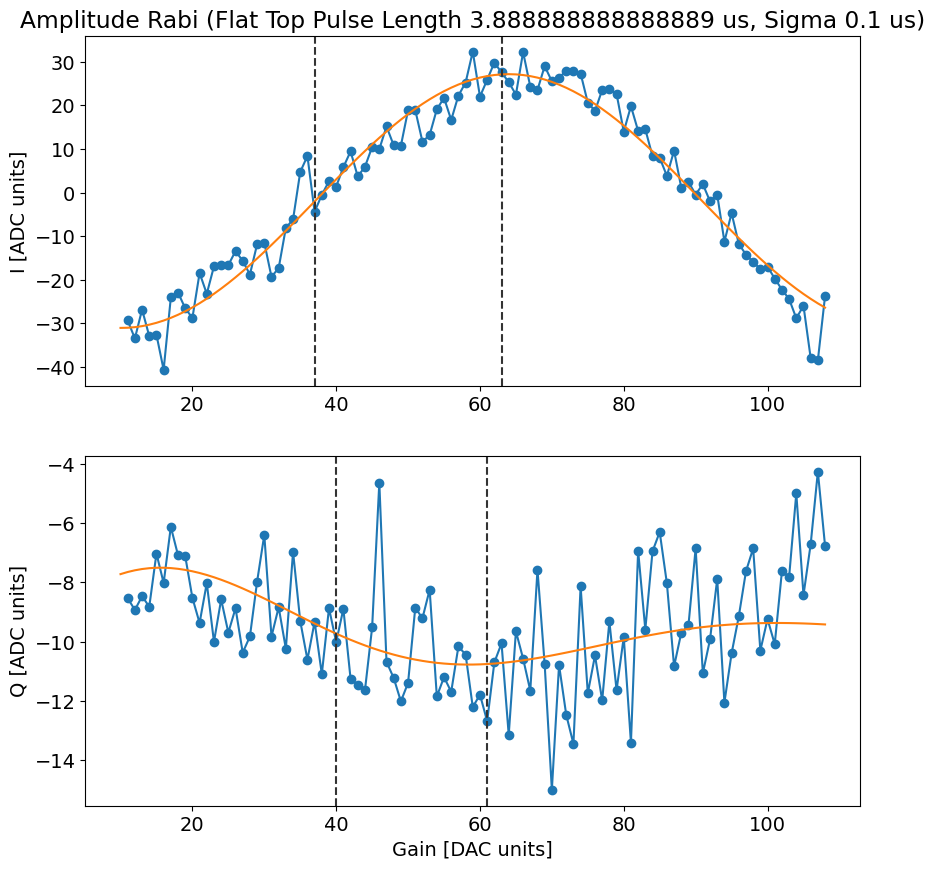

Length: 4.333333333333333
Job submitted: JOB-20260210-00205 (queue position: 1)

[0.1s] Job JOB-20260210-00205: pending

[14.3s] Job JOB-20260210-00205: running
[WORKER] Loading AmplitudeRabiExperiment from experiments.single_qubit.amplitude_rabi
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260210-00205_AmplitudeRabiExperiment.h5
[WORKER] Running experiment...
[WORKER] Setting coupler yoko current to 0.5mA according to hardware_cfg yaml...
[WORKER] Done setting coupler current
 98%|██████████████████████████████████▍| 19656/20000 [00:49<00:00, 398.83it/s]
[69.2s] Job JOB-20260210-00205: completed
100%|███████████████████████████████████| 20000/20000 [00:50<00:00, 398.82it/s]
Attempted to init fitparam 4 to -4.123387445887446, which is out of bounds -14.12784632034632 to -4.363246753246754. Instead init to -9.245546536796537
Attempted to init fitparam 4 to -9.245546536796537, which is out of bounds 7.081340009992379 to 68.48854956024324. Instead init to 37.784944785

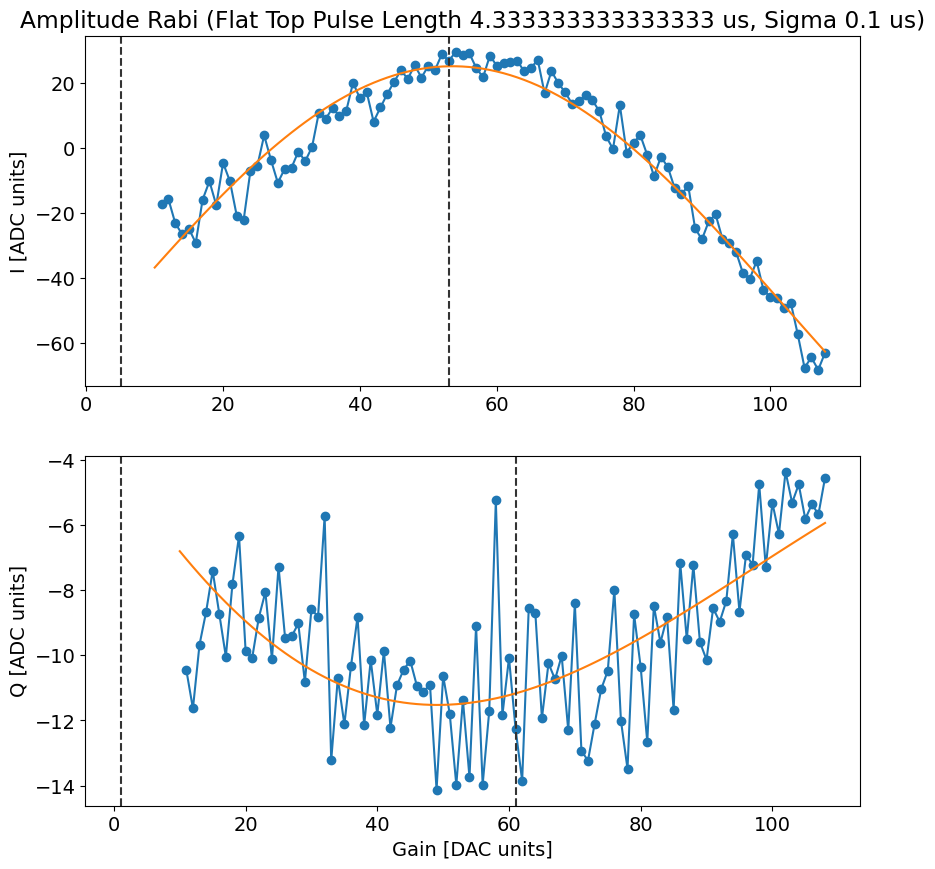

Length: 4.777777777777778
Job submitted: JOB-20260210-00207 (queue position: 1)

[0.1s] Job JOB-20260210-00207: pending

[14.2s] Job JOB-20260210-00207: running
[WORKER] Loading AmplitudeRabiExperiment from experiments.single_qubit.amplitude_rabi
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260210-00207_AmplitudeRabiExperiment.h5
[WORKER] Running experiment...
[WORKER] Setting coupler yoko current to 0.5mA according to hardware_cfg yaml...
[WORKER] Done setting coupler current
 98%|██████████████████████████████████▍| 19656/20000 [00:49<00:00, 398.76it/s]
[70.8s] Job JOB-20260210-00207: completed
100%|███████████████████████████████████| 20000/20000 [00:50<00:00, 398.76it/s]
Attempted to init fitparam 4 to -10.378108008658007, which is out of bounds 8.052809293665522 to 83.40716095695055. Instead init to 45.72998512530803
Saving D:\experiments\250119_qec\data\JOB-20260210-00207_AmplitudeRabiExperiment.h5
[WORKER] Saving expt object to: D:\experiments\250119_qec\exp

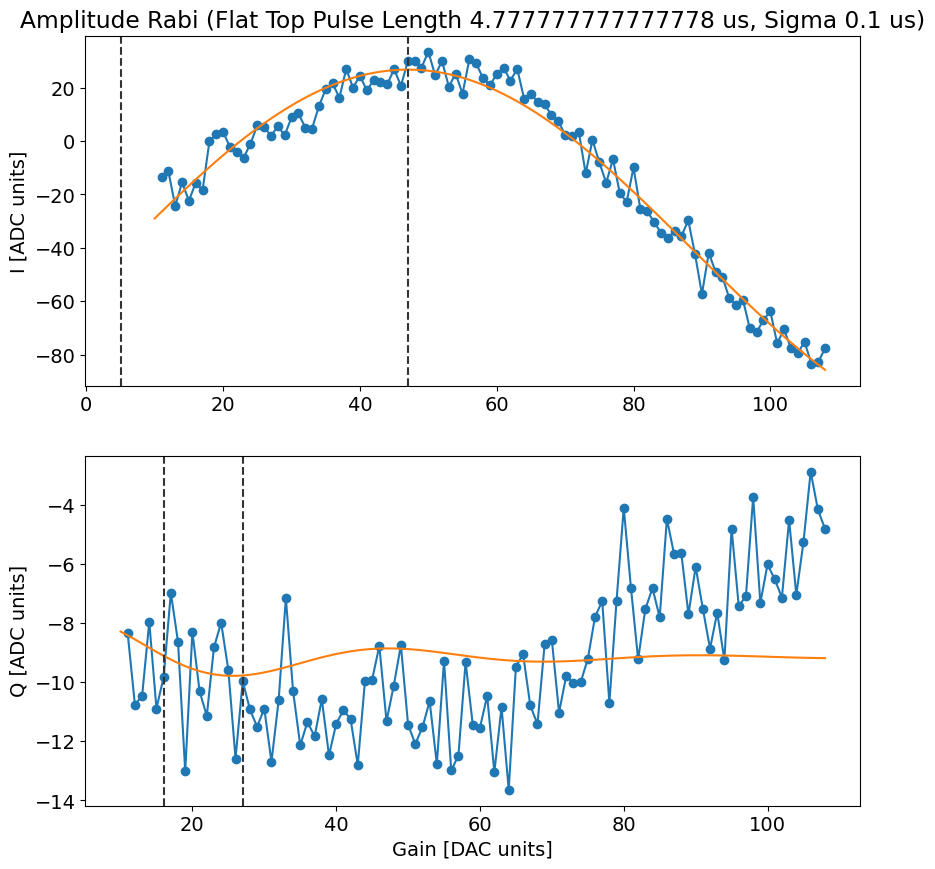

Length: 5.222222222222222
Job submitted: JOB-20260210-00209 (queue position: 1)

[0.1s] Job JOB-20260210-00209: pending

[12.4s] Job JOB-20260210-00209: running
[WORKER] Loading AmplitudeRabiExperiment from experiments.single_qubit.amplitude_rabi
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260210-00209_AmplitudeRabiExperiment.h5
[WORKER] Running experiment...
[WORKER] Setting coupler yoko current to 0.5mA according to hardware_cfg yaml...
[WORKER] Done setting coupler current
 98%|██████████████████████████████████▍| 19656/20000 [00:49<00:00, 398.70it/s]
[69.2s] Job JOB-20260210-00209: completed
100%|███████████████████████████████████| 20000/20000 [00:50<00:00, 398.68it/s]
Attempted to init fitparam 4 to -17.60894805194805, which is out of bounds -15.230064935064934 to -1.3568614718614718. Instead init to -8.293463203463203
Attempted to init fitparam 4 to -8.293463203463203, which is out of bounds 8.715875359106091 to 86.51775891768098. Instead init to 47.6168171

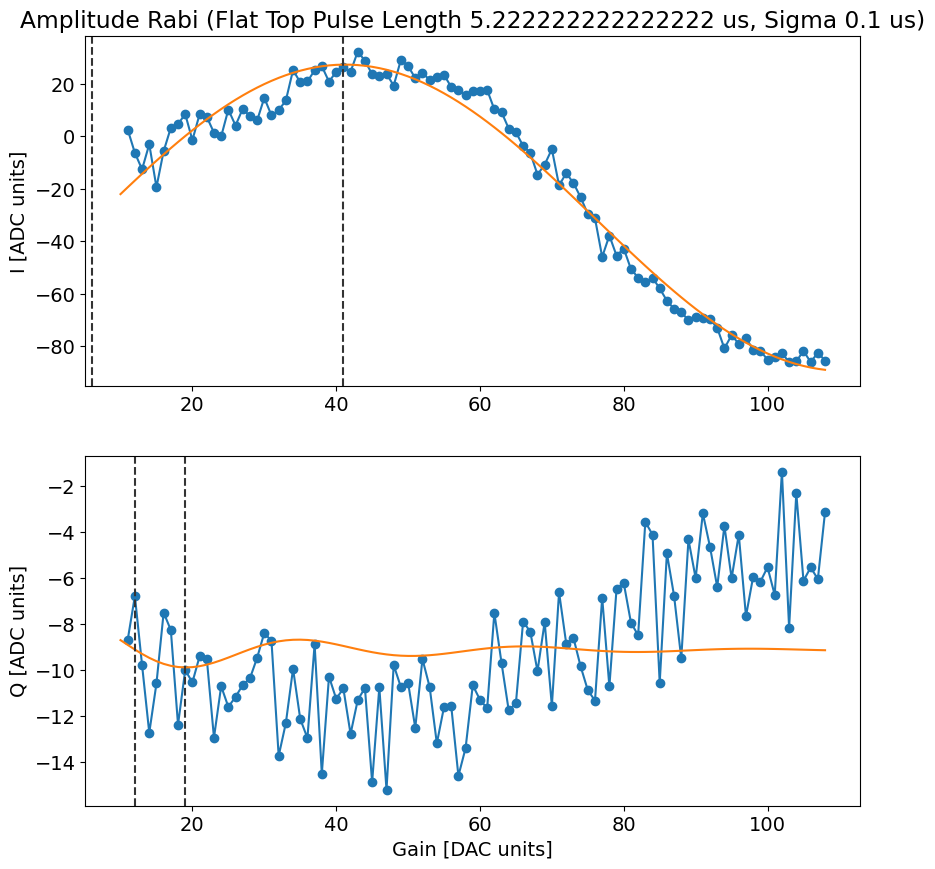

Length: 5.666666666666666
Job submitted: JOB-20260210-00211 (queue position: 1)

[0.1s] Job JOB-20260210-00211: pending

[14.1s] Job JOB-20260210-00211: running
[WORKER] Loading AmplitudeRabiExperiment from experiments.single_qubit.amplitude_rabi
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260210-00211_AmplitudeRabiExperiment.h5
[WORKER] Running experiment...
[WORKER] Setting coupler yoko current to 0.5mA according to hardware_cfg yaml...
[WORKER] Done setting coupler current
 90%|███████████████████████████████▌   | 18018/20000 [00:45<00:04, 398.61it/s]
[68.7s] Job JOB-20260210-00211: completed
100%|███████████████████████████████████| 20000/20000 [00:50<00:00, 398.63it/s]
Attempted to init fitparam 4 to -22.088604545454544, which is out of bounds -13.56103896103896 to -2.698138528138528. Instead init to -8.129588744588744
Attempted to init fitparam 4 to -8.129588744588744, which is out of bounds 8.430123736039087 to 90.08767773290661. Instead init to 49.25890073

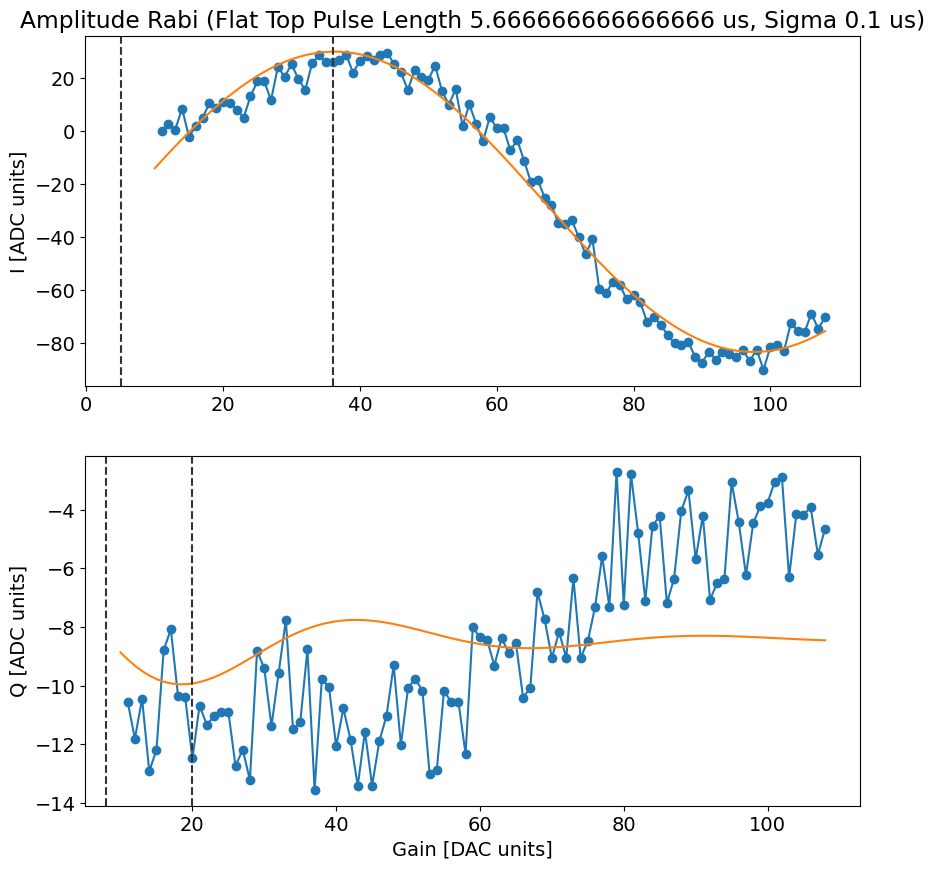

Length: 6.111111111111111
Job submitted: JOB-20260210-00213 (queue position: 1)

[0.1s] Job JOB-20260210-00213: pending

[14.1s] Job JOB-20260210-00213: running
[WORKER] Loading AmplitudeRabiExperiment from experiments.single_qubit.amplitude_rabi
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260210-00213_AmplitudeRabiExperiment.h5
[WORKER] Running experiment...
[WORKER] Setting coupler yoko current to 0.5mA according to hardware_cfg yaml...
[WORKER] Done setting coupler current
100%|███████████████████████████████████| 20000/20000 [00:50<00:00, 398.55it/s]
Attempted to init fitparam 4 to -24.159829978354978, which is out of bounds -13.863528138528139 to -2.0523701298701296. Instead init to -7.957949134199135
Attempted to init fitparam 4 to -7.957949134199135, which is out of bounds 8.759696321372662 to 90.41807790866665. Instead init to 49.58888711501965
Saving D:\experiments\250119_qec\data\JOB-20260210-00213_AmplitudeRabiExperiment.h5
[WORKER] Saving expt object t

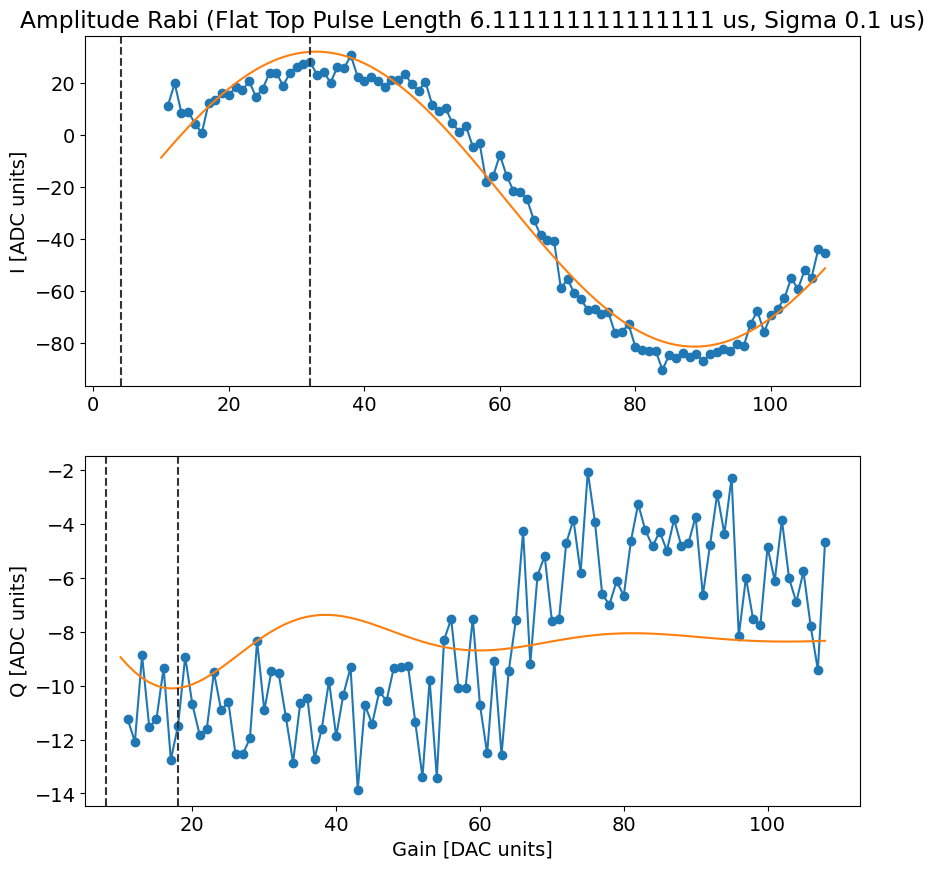

Length: 6.555555555555555
Job submitted: JOB-20260210-00214 (queue position: 1)

[0.1s] Job JOB-20260210-00214: pending

[2.4s] Job JOB-20260210-00214: running
[WORKER] Loading AmplitudeRabiExperiment from experiments.single_qubit.amplitude_rabi
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260210-00214_AmplitudeRabiExperiment.h5
[WORKER] Running experiment...
[WORKER] Setting coupler yoko current to 0.5mA according to hardware_cfg yaml...
[WORKER] Done setting coupler current
 90%|███████████████████████████████▌   | 18018/20000 [00:45<00:04, 398.48it/s]
[59.0s] Job JOB-20260210-00214: completed
100%|███████████████████████████████████| 20000/20000 [00:50<00:00, 398.48it/s]
Attempted to init fitparam 4 to -23.51913246753247, which is out of bounds -15.414556277056276 to -1.6924458874458872. Instead init to -8.553501082251081
Attempted to init fitparam 4 to -8.553501082251081, which is out of bounds 8.96144396697012 to 87.8669705883873. Instead init to 48.4142072776

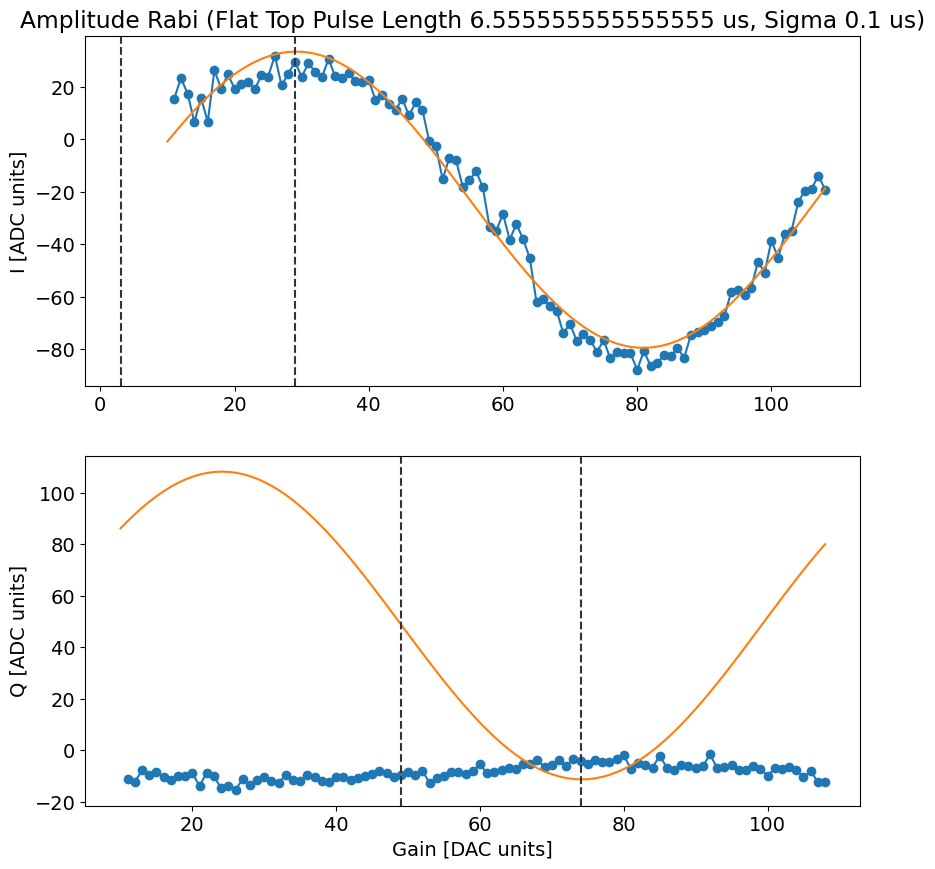

Length: 7.0
Job submitted: JOB-20260210-00215 (queue position: 1)

[0.1s] Job JOB-20260210-00215: pending

[2.1s] Job JOB-20260210-00215: running
[WORKER] Loading AmplitudeRabiExperiment from experiments.single_qubit.amplitude_rabi
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260210-00215_AmplitudeRabiExperiment.h5
[WORKER] Running experiment...
[WORKER] Setting coupler yoko current to 0.5mA according to hardware_cfg yaml...
[WORKER] Done setting coupler current
 90%|███████████████████████████████▌   | 18018/20000 [00:45<00:04, 398.40it/s]
[57.1s] Job JOB-20260210-00215: completed
100%|███████████████████████████████████| 20000/20000 [00:50<00:00, 398.40it/s]
Attempted to init fitparam 4 to -21.69995248917749, which is out of bounds -13.560541125541127 to -1.24487012987013. Instead init to -7.402705627705628
Attempted to init fitparam 4 to -7.402705627705628, which is out of bounds 7.25972727744285 to 90.0380770361849. Instead init to 48.648902156813875
Saving D:\

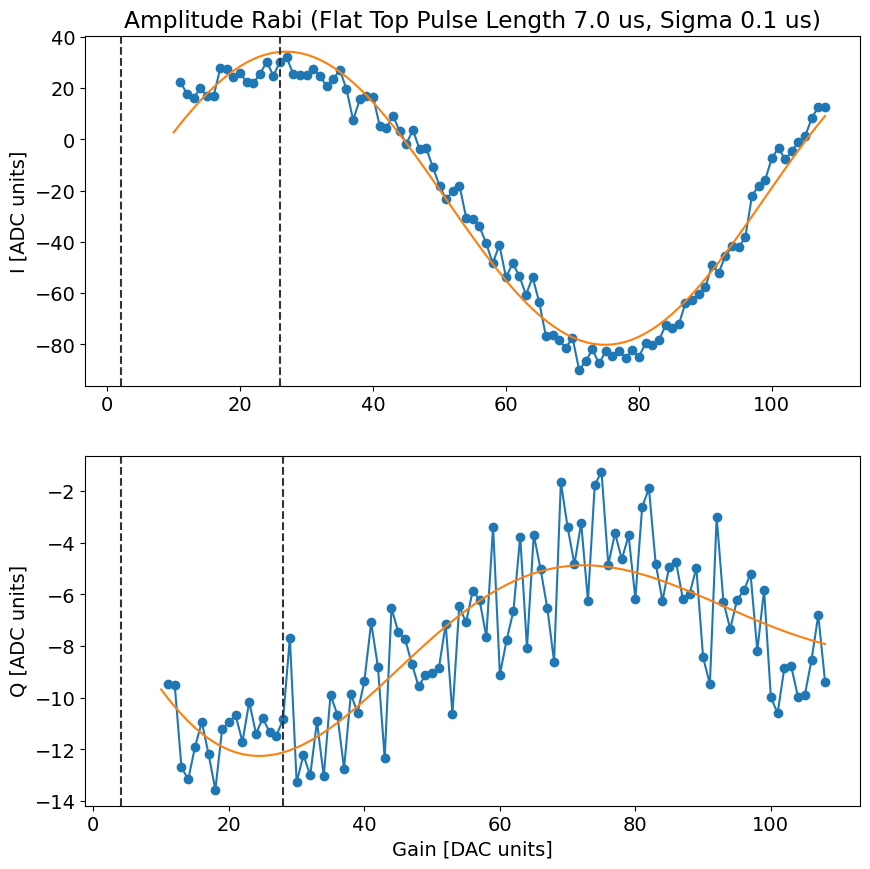

In [73]:
for idx, length in enumerate(length_vec):
    try:
        print(f"Length: {length}")
        amprabi = amprabi_runner.execute(
            go_kwargs=dict(analyze=True, display=True),
            flat_length=length,
            sigma_test=sigma_flat_top,
            step = 1, 
            expts = 100,
            # expts = 15,
            start=10,
        )

        gain_fit = amprabi.data['pi_gain_avgi']
        gain_vec[idx] = gain_fit
        print(f"Fitted gain: {gain_fit}")

        if USE_QUEUE:
            amprabi.display()

    except Exception as e:
        print(f"Error at length {length}: {e}")
        gain_vec[idx] = np.nan  # Mark this point as NaN to indicate failure
    

Text(0.5, 1.0, 'Fitted Gain vs Pulse Length')

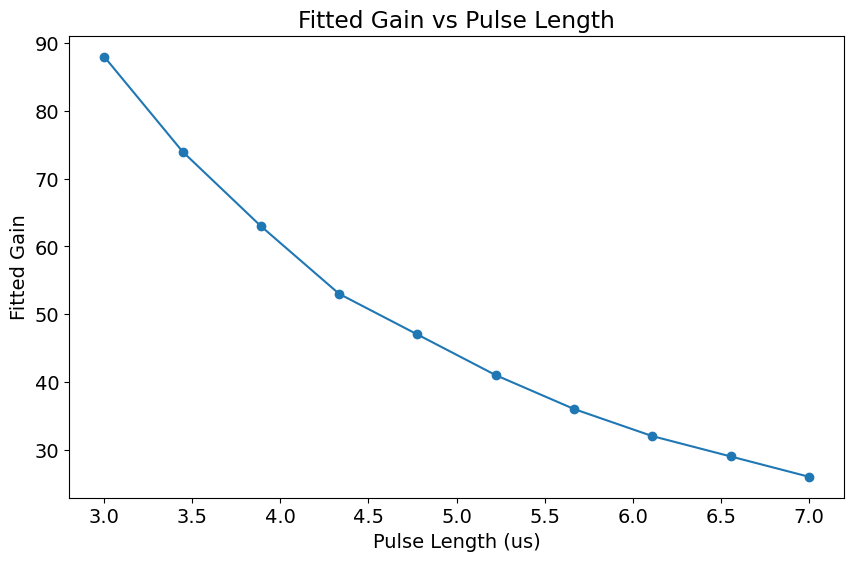

In [74]:
fig, ax = plt.subplots()
ax.plot(length_vec, gain_vec, marker='o')
ax.set_xlabel('Pulse Length (us)')
ax.set_ylabel('Fitted Gain')
ax.set_title('Fitted Gain vs Pulse Length')


### Then do the photon number resolved spectroscopy

In [75]:
photon_number_spectro_defaults = AttrDict(dict(
    start=3560, 
    step=0.1,
    expts=200,
    reps=2000,
    rounds=1,
    length=1,
    gain=400,
    sigma=0.1,
    qubits=[0],
    qubit=0,
    prepulse=False,
    pre_sweep_pulse=[],
    gate_based=False,
    relax_delay=250,
))

photon_number_spectro_runner = CharacterizationRunner(
    station=station,
    ExptClass=meas.single_qubit.pulse_probe_spectroscopy.PulseProbeSpectroscopyExperiment,
    default_expt_cfg=photon_number_spectro_defaults,
    job_client=client,
    use_queue=USE_QUEUE,
)

In [76]:
pre_sweep_pulse = mm_base_calib.prep_man_photon(man_no=1, photon_no=1)
pre_sweep_pulse = mm_base_calib.get_prepulse_creator(pre_sweep_pulse, station.hardware_cfg).pulse.tolist()
print(f"pre_sweep_pulse: {pre_sweep_pulse}")

pre_sweep_pulse: [[3563.149430155541, 3419.1760186165175, 1998.7491605509501], [9318, 8275, 8000], [0, 0, 0.5760814409699041], [0, 0, 0], [2, 2, 0], ['gauss', 'gauss', 'flat_top'], [0.035, 0.035, 0.005]]


Job submitted: JOB-20260210-00238 (queue position: 1)

[0.3s] Job JOB-20260210-00238: pending

[2.3s] Job JOB-20260210-00238: running
[WORKER] Loading PulseProbeSpectroscopyExperiment from experiments.single_qubit.pulse_probe_spectroscopy
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260210-00238_PulseProbeSpectroscopyExperiment.h5
[WORKER] Running experiment...
[WORKER] Setting coupler yoko current to 0.5mA according to hardware_cfg yaml...
[WORKER] Done setting coupler current
 98%|███████████████████████████████▍| 196560/200000 [01:39<00:01, 1976.14it/s]
[115.8s] Job JOB-20260210-00238: completed
100%|████████████████████████████████| 200000/200000 [01:41<00:00, 1976.36it/s]
Saving D:\experiments\250119_qec\data\JOB-20260210-00238_PulseProbeSpectroscopyExperiment.h5
[WORKER] Saving expt object to: D:\experiments\250119_qec\expt_objs\JOB-20260210-00238_expt.pkl

Job completed! Data: D:\experiments\250119_qec\data\JOB-20260210-00238_PulseProbeSpectroscopyExperiment

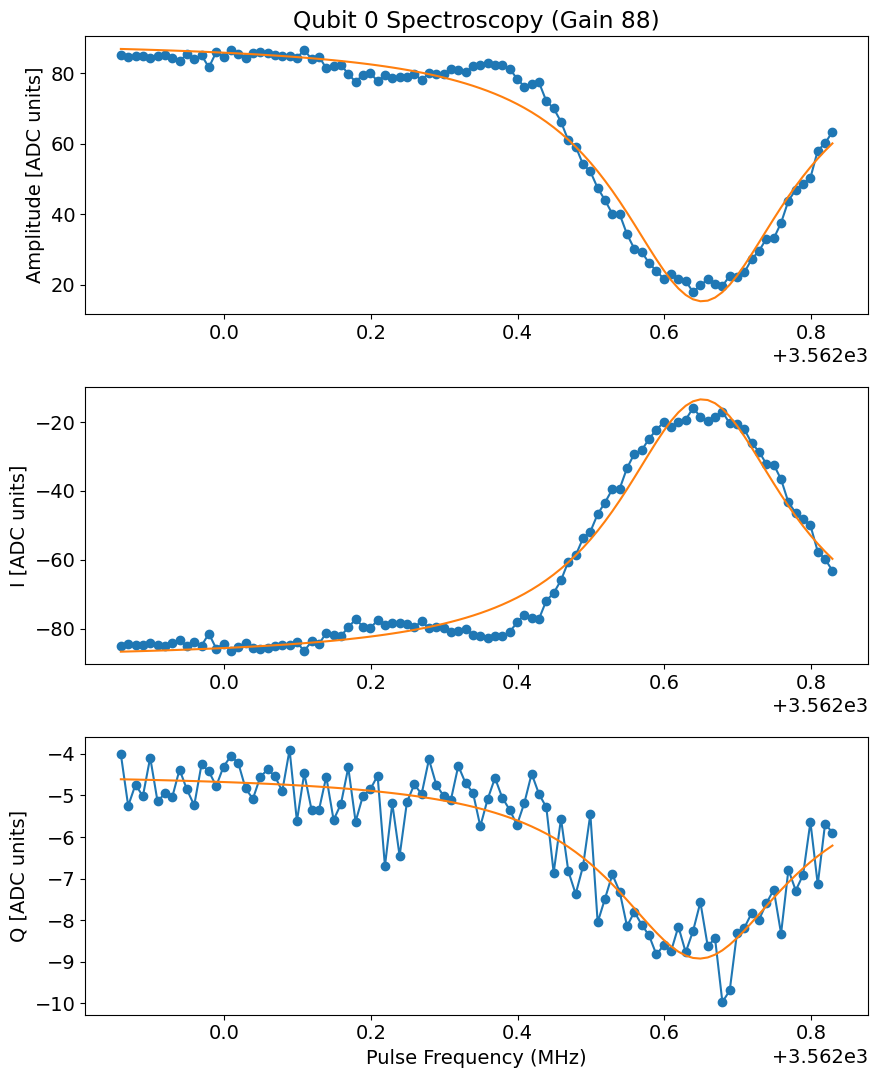

Job submitted: JOB-20260210-00240 (queue position: 1)

[0.1s] Job JOB-20260210-00240: pending

[20.3s] Job JOB-20260210-00240: running
[WORKER] Loading PulseProbeSpectroscopyExperiment from experiments.single_qubit.pulse_probe_spectroscopy
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260210-00240_PulseProbeSpectroscopyExperiment.h5
[WORKER] Running experiment...
[WORKER] Setting coupler yoko current to 0.5mA according to hardware_cfg yaml...
[WORKER] Done setting coupler current
100%|████████████████████████████████| 200000/200000 [01:41<00:00, 1972.71it/s]
Saving D:\experiments\250119_qec\data\JOB-20260210-00240_PulseProbeSpectroscopyExperiment.h5
[WORKER] Saving expt object to: D:\experiments\250119_qec\expt_objs\JOB-20260210-00240_expt.pkl

[133.8s] Job JOB-20260210-00240: completed

Job completed! Data: D:\experiments\250119_qec\data\JOB-20260210-00240_PulseProbeSpectroscopyExperiment.h5
Found peak in amps at [MHz] 3562.3696424917603, HWHM 0.13589064442369744
F

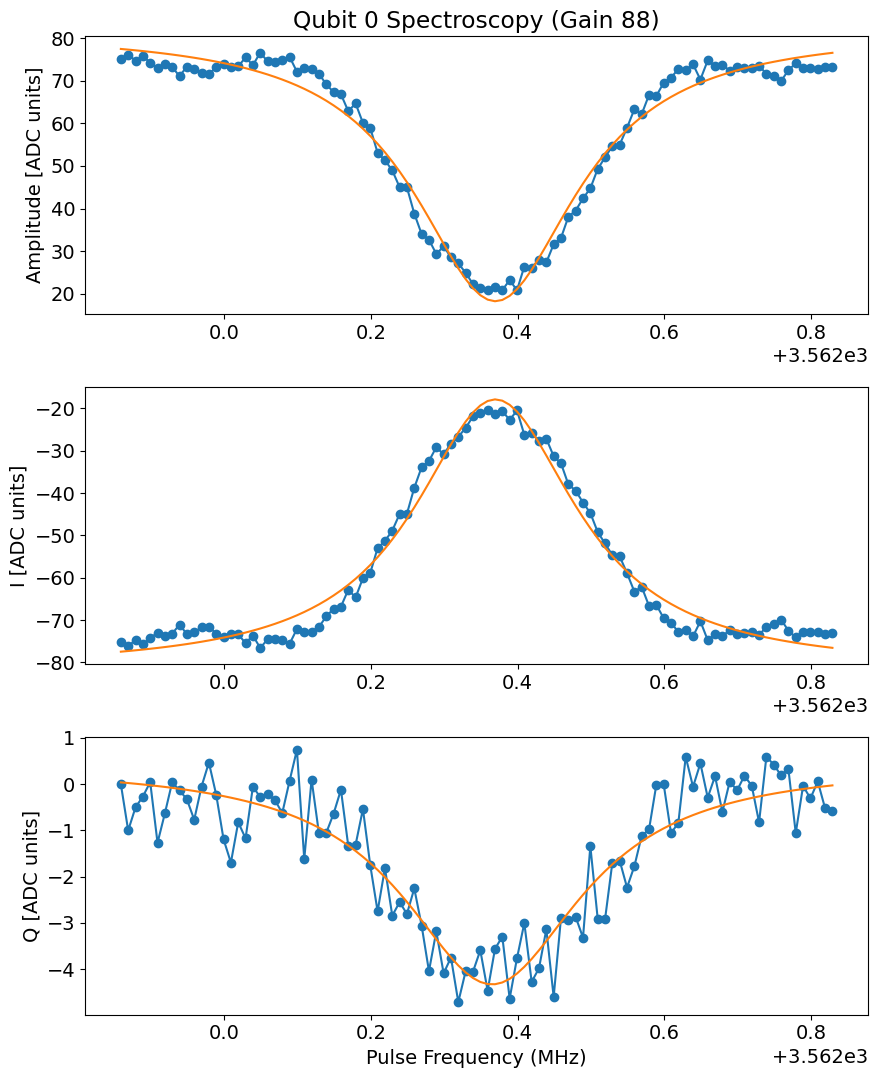

Job submitted: JOB-20260210-00242 (queue position: 1)

[0.1s] Job JOB-20260210-00242: pending

[20.5s] Job JOB-20260210-00242: running
[WORKER] Loading PulseProbeSpectroscopyExperiment from experiments.single_qubit.pulse_probe_spectroscopy
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260210-00242_PulseProbeSpectroscopyExperiment.h5
[WORKER] Running experiment...
[WORKER] Setting coupler yoko current to 0.5mA according to hardware_cfg yaml...
[WORKER] Done setting coupler current
 97%|███████████████████████████████▏| 194922/200000 [01:38<00:02, 1974.40it/s]
[132.4s] Job JOB-20260210-00242: completed
100%|████████████████████████████████| 200000/200000 [01:41<00:00, 1974.62it/s]
Saving D:\experiments\250119_qec\data\JOB-20260210-00242_PulseProbeSpectroscopyExperiment.h5
[WORKER] Saving expt object to: D:\experiments\250119_qec\expt_objs\JOB-20260210-00242_expt.pkl

Job completed! Data: D:\experiments\250119_qec\data\JOB-20260210-00242_PulseProbeSpectroscopyExperimen

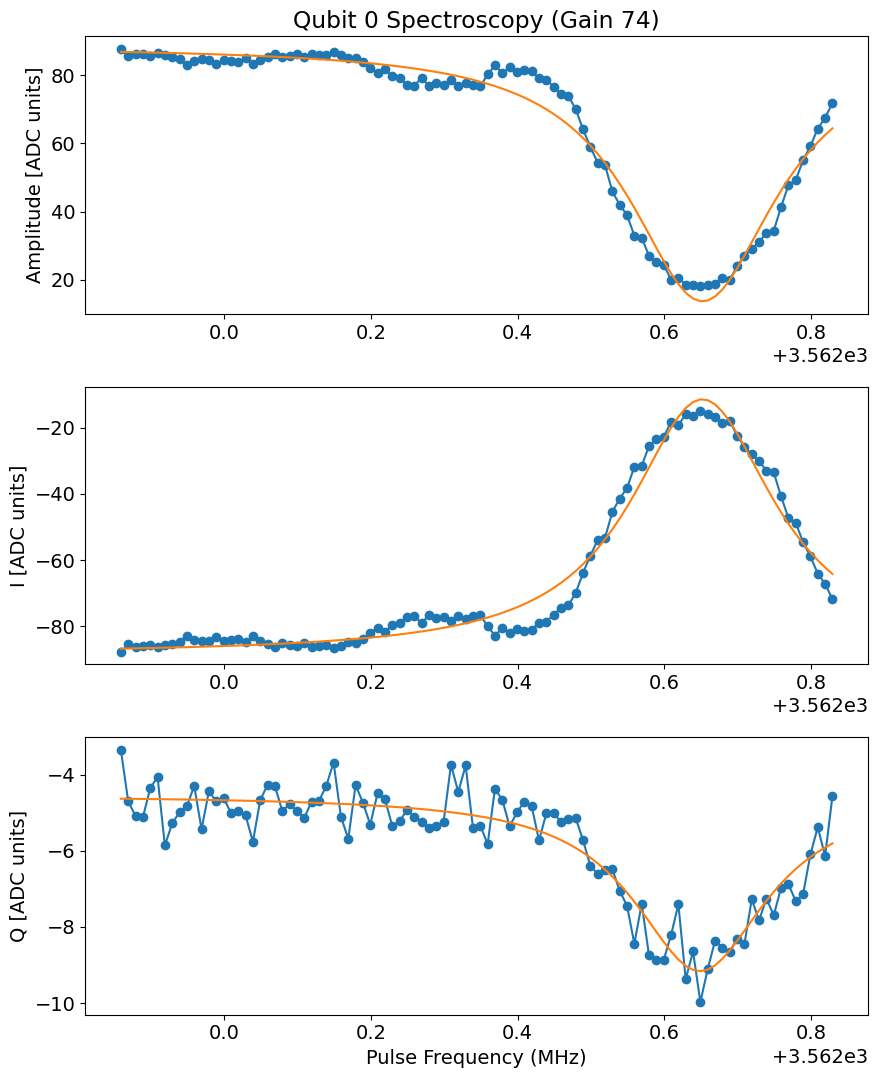

Job submitted: JOB-20260210-00244 (queue position: 1)

[0.1s] Job JOB-20260210-00244: pending

[20.4s] Job JOB-20260210-00244: running
[WORKER] Loading PulseProbeSpectroscopyExperiment from experiments.single_qubit.pulse_probe_spectroscopy
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260210-00244_PulseProbeSpectroscopyExperiment.h5
[WORKER] Running experiment...
[WORKER] Setting coupler yoko current to 0.5mA according to hardware_cfg yaml...
[WORKER] Done setting coupler current
 98%|███████████████████████████████▍| 196560/200000 [01:39<00:01, 1970.76it/s]
[134.7s] Job JOB-20260210-00244: completed
100%|████████████████████████████████| 200000/200000 [01:41<00:00, 1970.95it/s]
Saving D:\experiments\250119_qec\data\JOB-20260210-00244_PulseProbeSpectroscopyExperiment.h5
[WORKER] Saving expt object to: D:\experiments\250119_qec\expt_objs\JOB-20260210-00244_expt.pkl

Job completed! Data: D:\experiments\250119_qec\data\JOB-20260210-00244_PulseProbeSpectroscopyExperimen

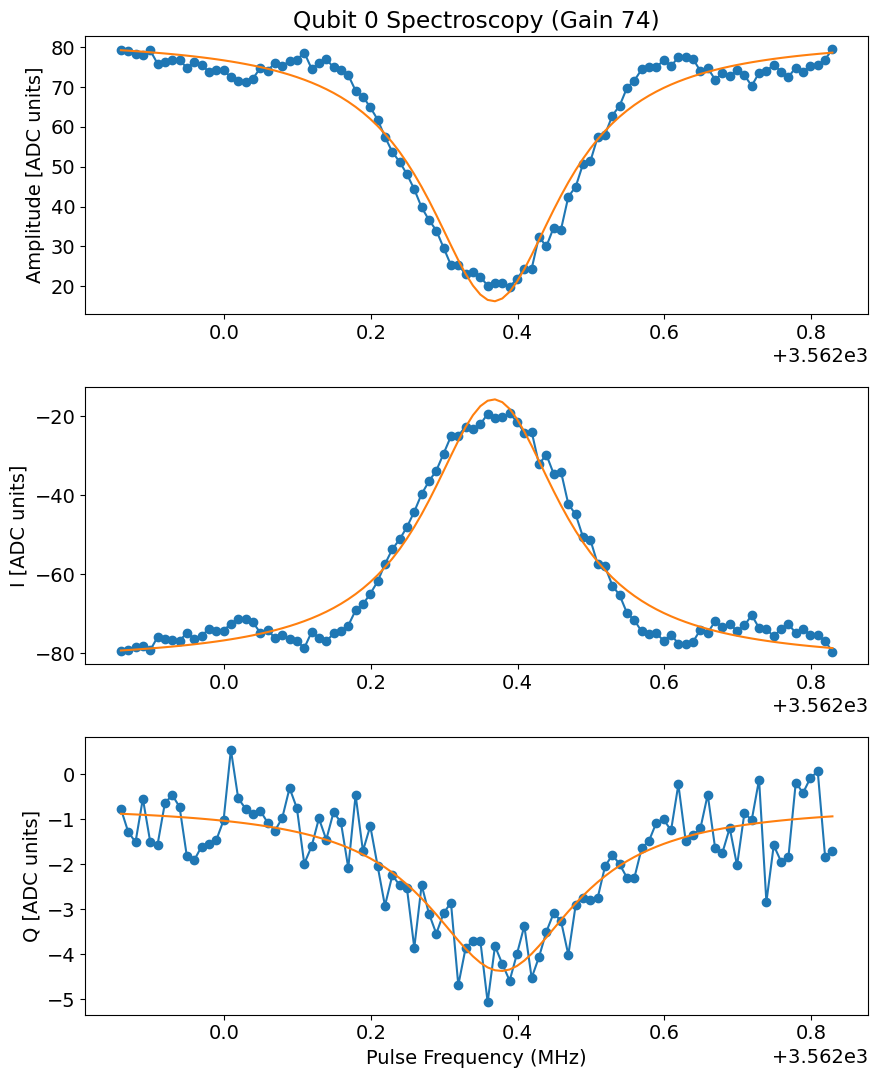

Job submitted: JOB-20260210-00246 (queue position: 1)

[0.1s] Job JOB-20260210-00246: pending

[20.6s] Job JOB-20260210-00246: running
[WORKER] Loading PulseProbeSpectroscopyExperiment from experiments.single_qubit.pulse_probe_spectroscopy
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260210-00246_PulseProbeSpectroscopyExperiment.h5
[WORKER] Running experiment...
[WORKER] Setting coupler yoko current to 0.5mA according to hardware_cfg yaml...
[WORKER] Done setting coupler current
 98%|███████████████████████████████▍| 196560/200000 [01:39<00:01, 1972.90it/s]
[133.9s] Job JOB-20260210-00246: completed
100%|████████████████████████████████| 200000/200000 [01:41<00:00, 1972.90it/s]
Saving D:\experiments\250119_qec\data\JOB-20260210-00246_PulseProbeSpectroscopyExperiment.h5
[WORKER] Saving expt object to: D:\experiments\250119_qec\expt_objs\JOB-20260210-00246_expt.pkl

Job completed! Data: D:\experiments\250119_qec\data\JOB-20260210-00246_PulseProbeSpectroscopyExperimen

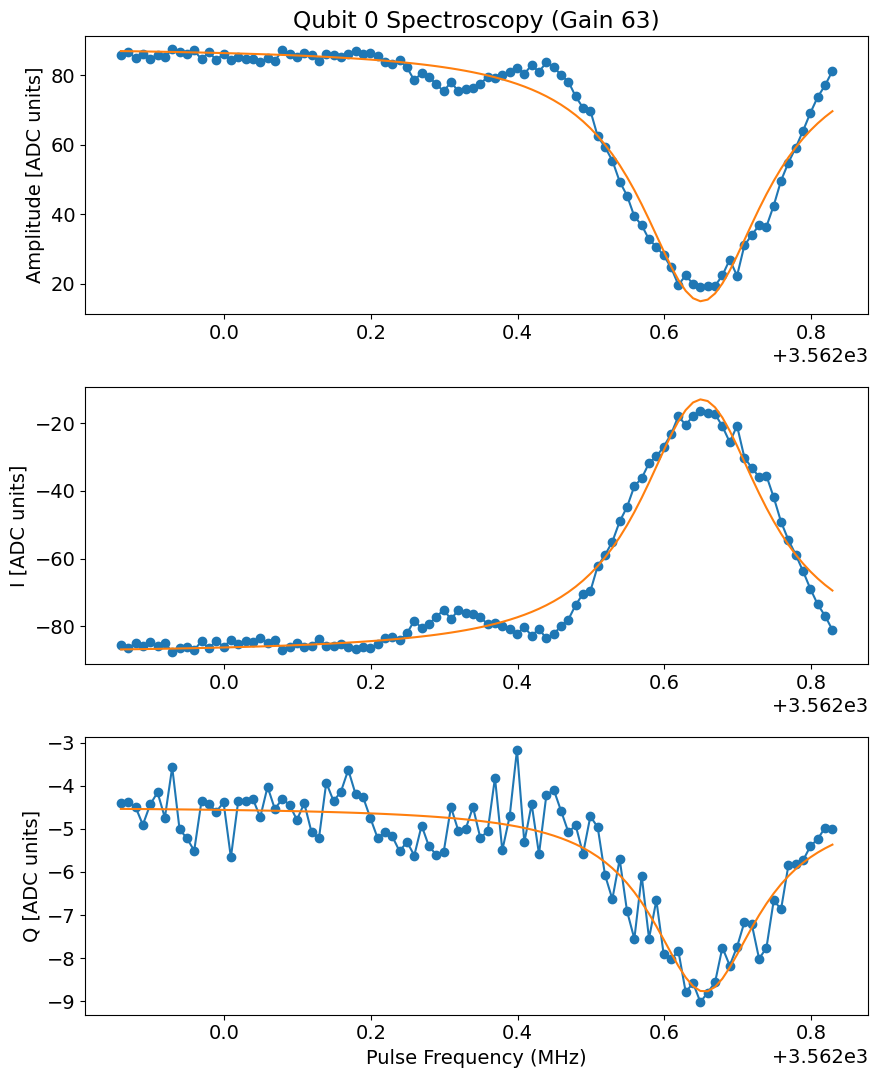

Job submitted: JOB-20260210-00248 (queue position: 1)

[0.1s] Job JOB-20260210-00248: pending

[20.6s] Job JOB-20260210-00248: running
[WORKER] Loading PulseProbeSpectroscopyExperiment from experiments.single_qubit.pulse_probe_spectroscopy
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260210-00248_PulseProbeSpectroscopyExperiment.h5
[WORKER] Running experiment...
[WORKER] Setting coupler yoko current to 0.5mA according to hardware_cfg yaml...
[WORKER] Done setting coupler current
100%|████████████████████████████████| 200000/200000 [01:41<00:00, 1969.25it/s]
Saving D:\experiments\250119_qec\data\JOB-20260210-00248_PulseProbeSpectroscopyExperiment.h5
[WORKER] Saving expt object to: D:\experiments\250119_qec\expt_objs\JOB-20260210-00248_expt.pkl

[136.0s] Job JOB-20260210-00248: completed

Job completed! Data: D:\experiments\250119_qec\data\JOB-20260210-00248_PulseProbeSpectroscopyExperiment.h5
Found peak in amps at [MHz] 3562.367885782725, HWHM 0.09488238475401704
Fo

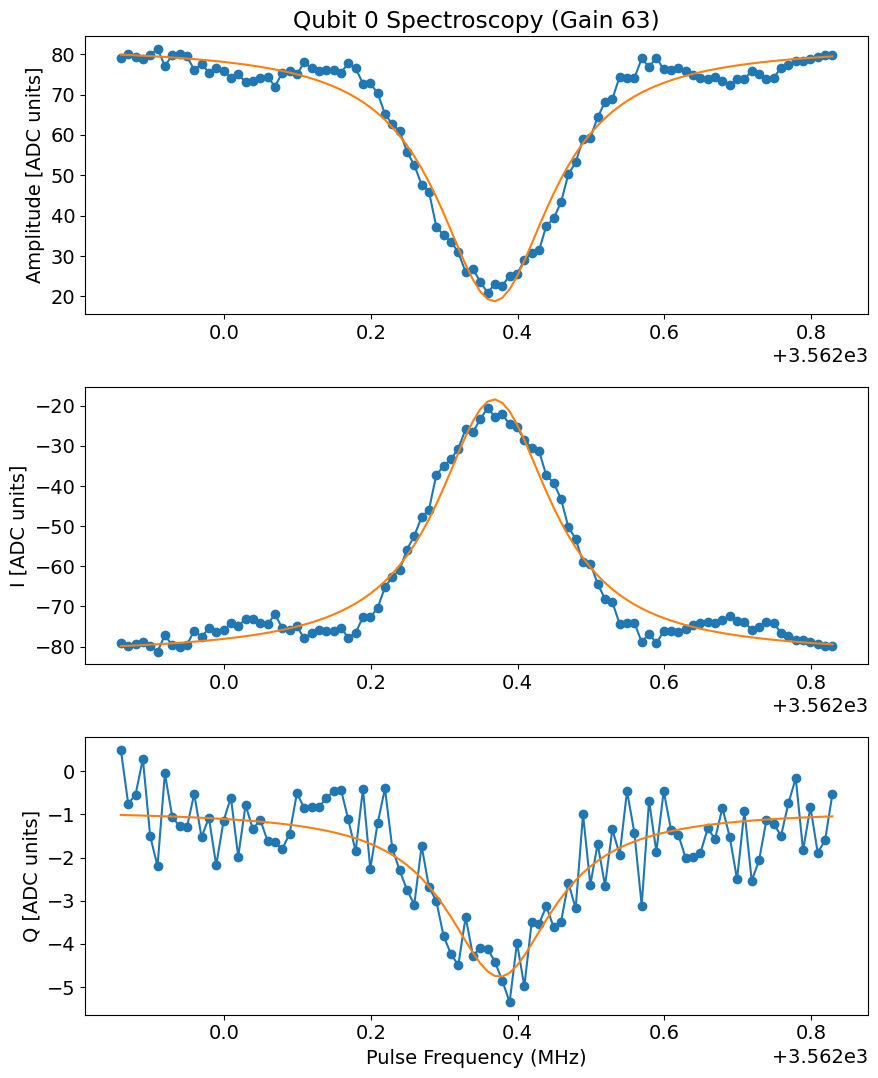

Job submitted: JOB-20260210-00250 (queue position: 1)

[0.1s] Job JOB-20260210-00250: pending

[20.2s] Job JOB-20260210-00250: running
[WORKER] Loading PulseProbeSpectroscopyExperiment from experiments.single_qubit.pulse_probe_spectroscopy
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260210-00250_PulseProbeSpectroscopyExperiment.h5
[WORKER] Running experiment...
[WORKER] Setting coupler yoko current to 0.5mA according to hardware_cfg yaml...
[WORKER] Done setting coupler current
 98%|███████████████████████████████▍| 196560/200000 [01:39<00:01, 1970.86it/s]
[133.4s] Job JOB-20260210-00250: completed
100%|████████████████████████████████| 200000/200000 [01:41<00:00, 1971.16it/s]
Saving D:\experiments\250119_qec\data\JOB-20260210-00250_PulseProbeSpectroscopyExperiment.h5
[WORKER] Saving expt object to: D:\experiments\250119_qec\expt_objs\JOB-20260210-00250_expt.pkl

Job completed! Data: D:\experiments\250119_qec\data\JOB-20260210-00250_PulseProbeSpectroscopyExperimen

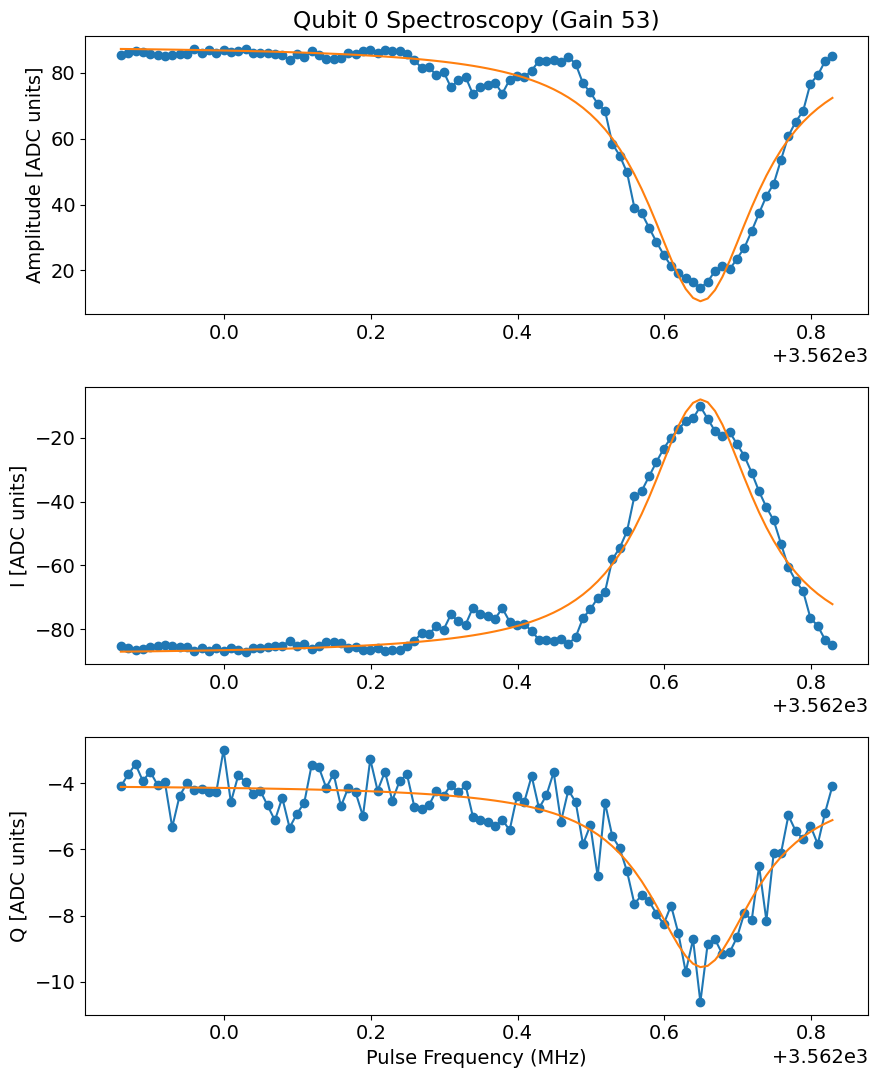

Job submitted: JOB-20260210-00252 (queue position: 1)

[0.1s] Job JOB-20260210-00252: pending

[20.3s] Job JOB-20260210-00252: running
[WORKER] Loading PulseProbeSpectroscopyExperiment from experiments.single_qubit.pulse_probe_spectroscopy
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260210-00252_PulseProbeSpectroscopyExperiment.h5
[WORKER] Running experiment...
[WORKER] Setting coupler yoko current to 0.5mA according to hardware_cfg yaml...
[WORKER] Done setting coupler current
 98%|███████████████████████████████▍| 196560/200000 [01:39<00:01, 1967.67it/s]
[133.8s] Job JOB-20260210-00252: completed
100%|████████████████████████████████| 200000/200000 [01:41<00:00, 1967.52it/s]
Saving D:\experiments\250119_qec\data\JOB-20260210-00252_PulseProbeSpectroscopyExperiment.h5
[WORKER] Saving expt object to: D:\experiments\250119_qec\expt_objs\JOB-20260210-00252_expt.pkl

Job completed! Data: D:\experiments\250119_qec\data\JOB-20260210-00252_PulseProbeSpectroscopyExperimen

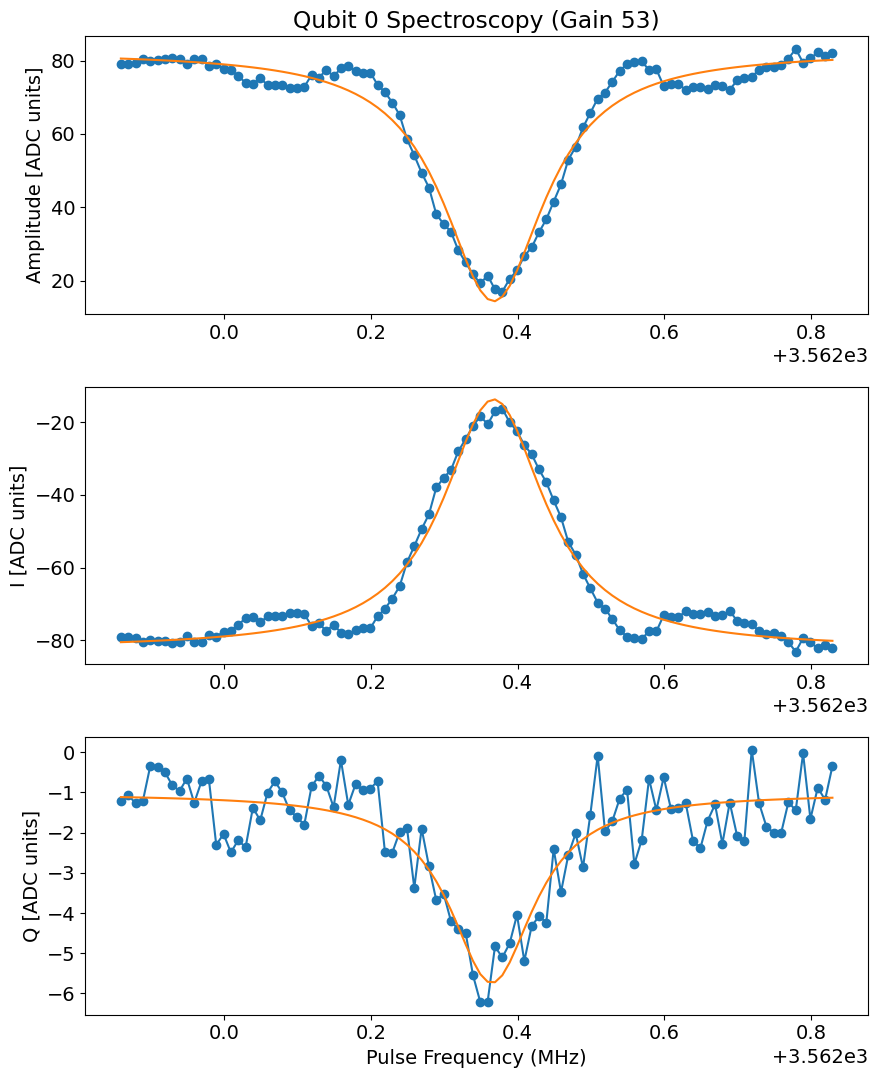

Job submitted: JOB-20260210-00254 (queue position: 1)

[0.1s] Job JOB-20260210-00254: pending

[20.2s] Job JOB-20260210-00254: running
[WORKER] Loading PulseProbeSpectroscopyExperiment from experiments.single_qubit.pulse_probe_spectroscopy
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260210-00254_PulseProbeSpectroscopyExperiment.h5
[WORKER] Running experiment...
[WORKER] Setting coupler yoko current to 0.5mA according to hardware_cfg yaml...
[WORKER] Done setting coupler current
 40%|█████████████▏                   | 80262/200000 [00:40<01:00, 1969.07it/s]

In [ ]:
span = 1
expt = 100
step = span / expt
start = station.hardware_cfg.device.qubit.f_ge[0] - span*0.8
length = 15


for idx, length in enumerate(length_vec):

    try:
        photon_number_spectro_g = photon_number_spectro_runner.execute(
            go_kwargs=dict(analyze=True, display=True, save=True),
            pre_sweep_pulse=pre_sweep_pulse,
            prepulse=False,
            gate_based=False,
            start=start,
            length=length,
            sigma=sigma_flat_top,
            gain=int(gain_vec[idx]),
            step=step,
            expts=expt,
            relax_delay=500,
        )

        if USE_QUEUE:
            photon_number_spectro_g.display()

        photon_number_spectro_e = photon_number_spectro_runner.execute(
        go_kwargs=dict(analyze=True, display=True, save=True),
        pre_sweep_pulse=pre_sweep_pulse,
        prepulse=True,
        gate_based=False,
        start=start,
        length=length,
        sigma=sigma_flat_top,
        gain=int(gain_vec[idx]),
        step=step,
        expts=expt,
        relax_delay=500,
        )

        if USE_QUEUE:
            photon_number_spectro_e.display()




    except Exception as e:
        print(f"Error at length {length}: {e}")


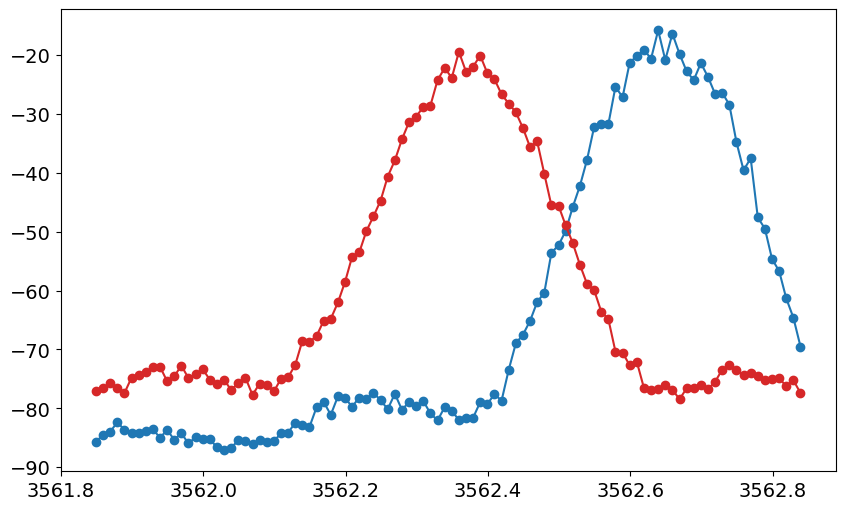

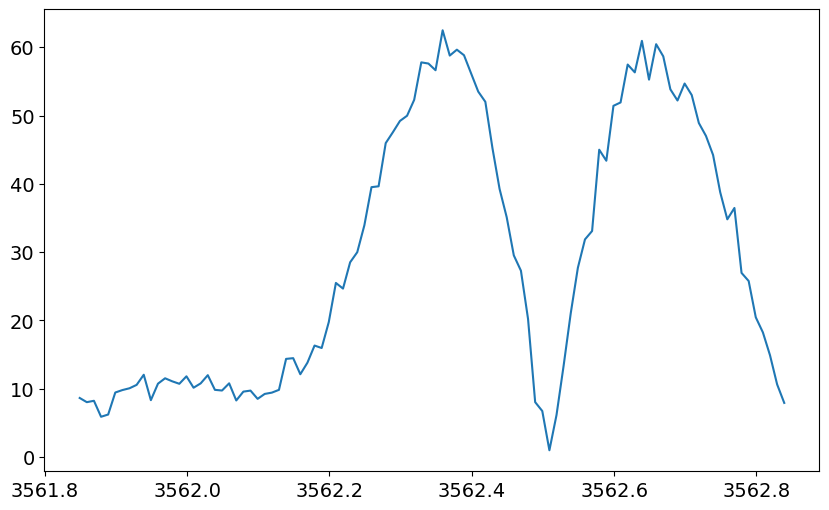

In [89]:
x_g = photon_number_spectro_g.data['xpts']
x_e = photon_number_spectro_e.data['xpts']
y_g =  photon_number_spectro_g.data['avgi']
y_e =  photon_number_spectro_e.data['avgi']
diff = np.abs(y_g - y_e)

fig, ax = plt.subplots()
ax.plot(x_g, y_g, '-o', label='Qubit in $|g\\rangle$', color='tab:blue')
ax.plot(x_e, y_e, '-o', label='Qubit in $|e\\rangle$', color='tab:red')

fig2, ax2 = plt.subplots()
ax2.plot(x_g, diff, label='|g-e|')

# Calibrate the joint parity measurement 

In [ ]:
from joint_parity_calibrator import JointParityCalibrator
calibrator = JointParityCalibrator(station, client, use_queue=USE_QUEUE, debug=True)

In [ ]:
man_mode_no = 1
stor_mode_no = 1
stor_name = f'M1-S{stor_mode_no}'
chi_ge = station.hardware_cfg.device.manipulate.chi_ge[man_mode_no - 1]
g_bs_guess = np.sqrt(3)/2 * np.abs(chi_ge)*0.5
rate_list = g_bs_guess * np.linspace(0.9, 1.1, 5)


In [ ]:
alice_result = calibrator.sweep_beam_splitter_rate(
    rate_list,
    alpha_amplitude=1.0,
    target_phase_tol=0.05,
    target_phase_diff=0.9,
    wigner_n_points=50, 
    fit_degree=3,
)

In [ ]:
wait_time_list = alice_result['fitted_calibration']['pi_length'] * np.linspace(0.9, 1.1, 5) * 2
bob_result = calibrator.calibrate_wait_time(
    wait_time_list,
    fixed_params=alice_result['fitted_calibration'],
    wigner_n_points=50, 
    fit_degree=3,
    target_phase_diff=0.9,
    target_phase_tol=0.05,
)

In [ ]:
freq_bs = alice_result['fitted_calibration']['freq_bs']
gain = alice_result['fitted_calibration']['gain']
pi_length = alice_result['fitted_calibration']['pi_length']
wait_time = bob_result['optimal_wait'] 

In [ ]:
station.ds_storage.update_joint_parity(
    stor_name=stor_name,
    freq_bs=freq_bs,
    gain=gain,
    length=pi_length * 2,
    wait_time=wait_time
)
print(f"Stored joint parity params for {stor_name}: freq={freq_bs:.4f} MHz, gain={gain}, length={pi_length*2:.4f} us, wait_time={wait_time} us")

# Optionally snapshot to save to config version
station.snapshot_man1_storage_swap(update_main=True)
# station.preview_config_update()

## Check the joint parity measurement

In [5]:
# 1. Define defaults
parity_phase_defaults = AttrDict(dict(
    # Phase sweep parameters
    start=0,
    step=3.6,  # 100 points over 360 degrees
    expts=100,
    # Averaging
    reps=100,
    rounds=1,
    # Storage modes
    storage_swap=3,      # M1-S3 - swapped to/from manipulate
    storage_parity=1,    # M1-S1 - probed by joint parity (NOT swapped)
    manipulate=1,
    # State preparation: '00', '10', '01', or '11'
    state_start='00',
    # Pulse mode
    parity_fast=True,
    # Reset options
    active_reset=False,
    man_reset=False,
    storage_reset=False,
    # Optional prepulse
    prepulse=False,
    gate_based=False,
    # Qubit selection
    qubits=[0],
    relax_delay=2500,
))


# 2. Optional postprocessor (extract results, update config)
def parity_phase_postproc(station, expt):
    # Example: extract fitted phase offset if needed
    if 'fit_avgi' in expt.data:
        phase_offset = expt.data['fit_avgi'][2]  # phase parameter from sin fit
        print(f"Fitted phase offset: {phase_offset:.2f} deg")
    return None

# 3. Create the runner
parity_phase_runner = CharacterizationRunner(
    station=station,
    ExptClass=meas.ParityPhaseExperiment,
    default_expt_cfg=parity_phase_defaults,
    postprocessor=parity_phase_postproc,  # optional
    job_client=client,
    use_queue=USE_QUEUE,
)




Job submitted: JOB-20260210-00039 (queue position: 1)

[0.1s] Job JOB-20260210-00039: pending

[2.2s] Job JOB-20260210-00039: running
[WORKER] Loading ParityPhaseExperiment from experiments.dual_rail.parity_phase
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260210-00039_ParityPhaseExperiment.h5
[WORKER] Running experiment...
[WORKER] Setting coupler yoko current to 0.5mA according to hardware_cfg yaml...
[WORKER] Done setting coupler current
States:   0%|                                            | 0/4 [00:00<?, ?it/s]
=== Running state_start='00' ===
CAREFULL - setting gain to 0 for testing purposes
f_ge_fast: 3562.8471836557837
gain_fast: 7774
sigma_fast: 0.02
no AC STARK CORRECTION FOR FAST PARITY YET

States:  25%|█████████                           | 1/4 [00:25<01:15, 25.27s/it]
=== Running state_start='10' ===
CAREFULL - setting gain to 0 for testing purposes
State preparation sequence for state_start='10': [['multiphoton', 'g0-e0', 'pi', 0], ['multiphoton',

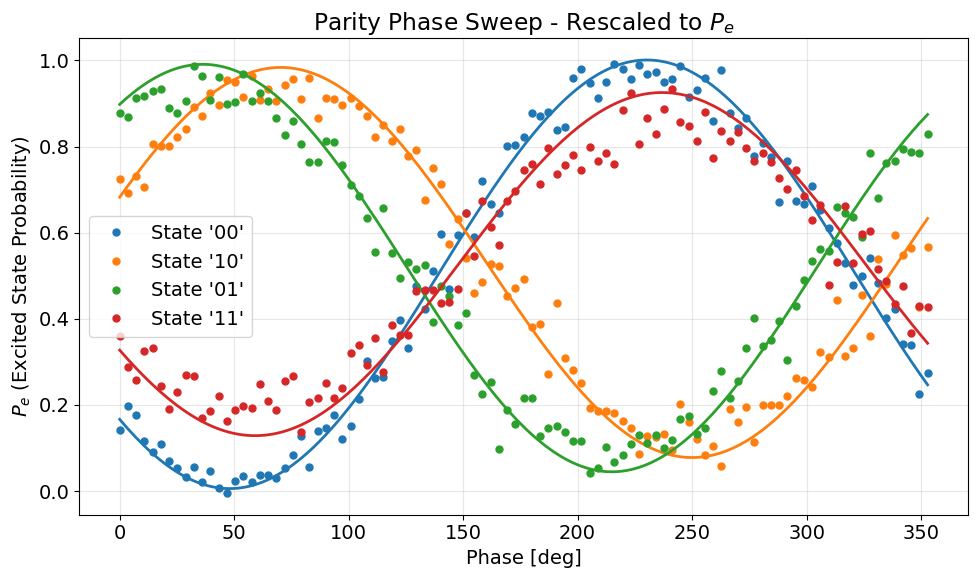


=== Fit Summary ===
State '00': period=364.5 deg, phase=222.6 deg, amplitude=0.498, offset=0.503
State '10': period=359.3 deg, phase=19.6 deg, amplitude=0.453, offset=0.531
State '01': period=357.3 deg, phase=53.4 deg, amplitude=0.473, offset=0.518
State '11': period=355.4 deg, phase=210.1 deg, amplitude=0.398, offset=0.527


In [6]:
# 5. Execute with optional overrides
parity_phase_expt = parity_phase_runner.execute(
    # Override any defaults via kwargs:
    storage_swap=3,
    storage_parity=1,
    state_start=['00', '10', '01', '11'],  # '00', '10', '01', or '11'
    reps=100,
    go_kwargs=dict(analyze=True, display=True),
    parity_fast=True,
    **active_reset_dict,
)

# If using queue, display results manually
if USE_QUEUE:
    parity_phase_expt.analyze()
    parity_phase_expt.display()

In [52]:
# ============================================
# Dual Rail Sandbox Experiment
# ============================================

# 1. Define defaults
dual_rail_sandbox_defaults = AttrDict(dict(
    # Averaging
    reps=500,
    rounds=1,
    # Storage modes for dual rail
    storage_1=1,             # First storage mode (e.g., S1)
    storage_2=3,             # Second storage mode (e.g., S3)
    manipulate=1,            # Manipulate mode
    # State preparation: '00', '10', '01', '11' or list
    state_start='00',
    # Wait and parity options
    wait_time=0,             # Wait time in us (0 = skip)
    repeat_count=1,          # Number of (wait + joint_parity) loops
    parity_flag=False,       # If True, measure joint parity during repeat
    parity_fast=False,       # If True, use fast multiphoton hpi pulses
    # Reset options
    active_reset=False,
    reset_before_dual_rail=False,
    reset_after_dual_rail=False,
    # Qubit selection
    qubits=[0],
    relax_delay=10000,
))


# 2. Optional postprocessor
def dual_rail_sandbox_postproc(station, expt):
    """Post-process dual rail sandbox results."""
    # Analyze with post-selection
    expt.analyze(post_select=True)
    
    # Print summary
    state_list = expt.data.get('states', ['00'])
    for state in state_list:
        pops = expt.data.get(f'pop_{state}', {})
        post_count = expt.data.get(f'post_select_count_{state}', expt.cfg.expt.reps)
        print(f"State |{state}>: 00={pops.get('00',0):.3f}, 10={pops.get('10',0):.3f}, "
              f"01={pops.get('01',0):.3f}, 11={pops.get('11',0):.3f} "
              f"(post-sel: {post_count}/{expt.cfg.expt.reps})")
    return None


# 3. Create the runner
dual_rail_sandbox_runner = CharacterizationRunner(
    station=station,
    ExptClass=meas.DualRailSandboxExperiment,
    default_expt_cfg=dual_rail_sandbox_defaults,
    postprocessor=dual_rail_sandbox_postproc,
    job_client=client,
    use_queue=USE_QUEUE,
)



In [56]:
wait_list = np.arange(0, 10000, 400)
# wait_list = 0
print('wait_list:', wait_list)

wait_list: [   0  400  800 1200 1600 2000 2400 2800 3200 3600 4000 4400 4800 5200
 5600 6000 6400 6800 7200 7600 8000 8400 8800 9200 9600]


In [57]:
# 4. Execute - Basic state preparation test (no joint parity)
dual_rail_expt = dual_rail_sandbox_runner.execute(
    state_start=['00','10', '01', '11'],  # Logical states
    storage_1=1,
    storage_2=3,
    wait_time=wait_list,
    parity_flag=False,
    reset_before_dual_rail=False,
    reps=1500,
    go_kwargs=dict(analyze=False, display=False),
    **active_reset_dict,
)



# # 5. Execute with joint parity monitoring
# dual_rail_parity_expt = dual_rail_sandbox_runner.execute(
#     state_start=['10', '01'],  # Logical states
#     storage_1=1,
#     storage_2=3,
#     wait_time=10,              # 10 us wait between joint parity checks
#     repeat_count=5,            # Check parity 5 times
#     parity_flag=True,          # Enable joint parity measurement
#     parity_fast=False,
#     reps=200,
#     go_kwargs=dict(analyze=False, display=False),
# )

# if USE_QUEUE:
#     dual_rail_parity_expt.analyze(post_select=True)  # Post-select on 10/01 subspace
#     dual_rail_parity_expt.display(show_iq=True)


Job submitted: JOB-20260210-00166 (queue position: 1)

[0.1s] Job JOB-20260210-00166: pending

[2.1s] Job JOB-20260210-00166: running
[WORKER] Loading DualRailSandboxExperiment from experiments.dual_rail.dual_rail_sandbox
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260210-00166_DualRailSandboxExperiment.h5
[WORKER] Running experiment...
[WORKER] Setting coupler yoko current to 0.5mA according to hardware_cfg yaml...
[WORKER] Done setting coupler current

=== [1/100] state='00', repeat=1, wait=0 ===
needs a pretty long sync here due to the measurement
100%|██████████████████████████████████████| 1500/1500 [00:15<00:00, 99.69it/s]

=== [2/100] state='00', repeat=1, wait=400 ===
needs a pretty long sync here due to the measurement
100%|██████████████████████████████████████| 1500/1500 [00:15<00:00, 95.87it/s]

=== [3/100] state='00', repeat=1, wait=800 ===
needs a pretty long sync here due to the measurement
100%|██████████████████████████████████████| 1500/1500 [00:

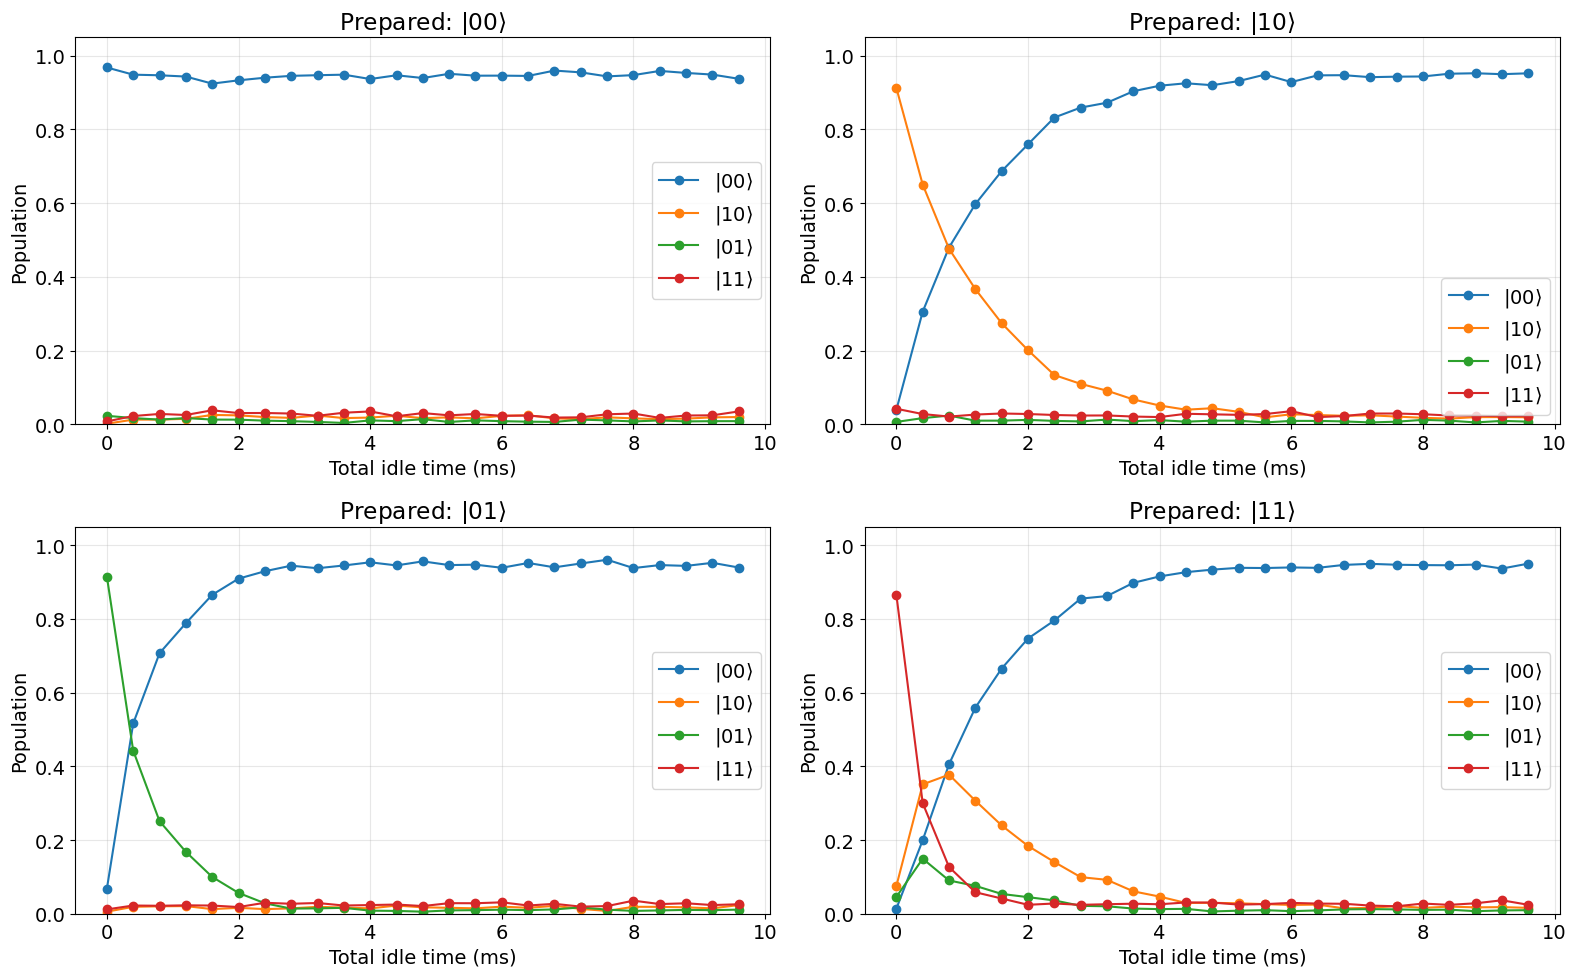

D:\python\multimode_expts\fitting\fitting.py:56: RuntimeWarning: overflow encountered in exp
  return y0 + yscale*np.exp(-(x-x0)/decay)


p1 fit params for 00: [ 0.68028465 -0.89670617 -0.25385869  0.6378989 ]
p1 fit cov for 00: [[ 3.70272414e-04 -2.20653695e+03 -1.56968665e+03  1.30863773e-03]
 [-2.20653695e+03  1.54711584e+12  1.10058738e+12 -2.51614379e+04]
 [-1.56968665e+03  1.10058738e+12  7.82935931e+11 -1.78993623e+04]
 [ 1.30863773e-03 -2.51614379e+04 -1.78993623e+04  2.94920178e-02]]
p1 fit params for 10: [ 0.25616375  0.92044307 -3.16629836 16.30665021]
p1 fit cov for 10: [[ 5.98123789e-01 -8.04380907e+04  1.42657285e+06 -1.69543688e+01]
 [-8.04380907e+04  1.70871112e+11 -3.03042460e+12  2.18399656e+06]
 [ 1.42657285e+06 -3.03042460e+12  5.37450311e+13 -3.87332592e+07]
 [-1.69543688e+01  2.18399656e+06 -3.87332592e+07  4.83538379e+02]]
p1 fit params for 01: [ 0.66910196 -0.97440288 -0.5207532   2.32601013]
p1 fit cov for 01: [[3.08196688e-03 2.19530321e+04 5.22287781e+04 3.24435282e-02]
 [2.19530321e+04 1.97602304e+12 4.70118540e+12 4.26583332e+05]
 [5.22287781e+04 4.70118540e+12 1.11846591e+13 1.01489055e+06]


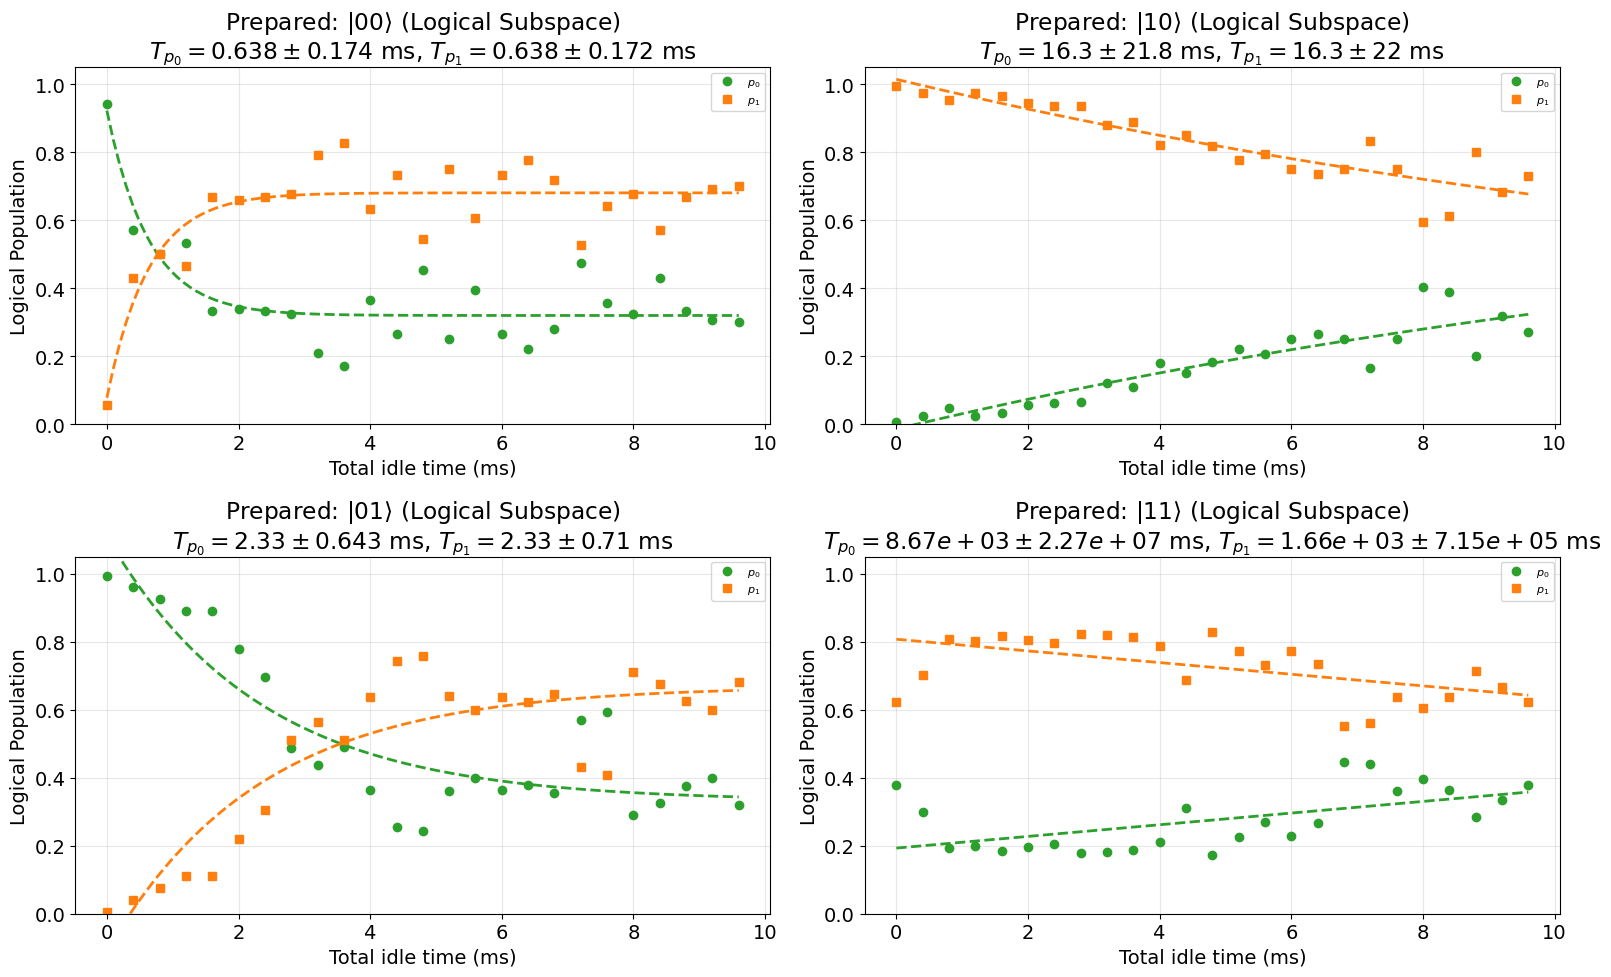

In [58]:
# If using queue, analyze and display manually
if USE_QUEUE:
    dual_rail_expt.analyze(post_select=False)
    dual_rail_expt.display(show_iq=False, show_histograms=False, log_scale=True)
